In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

In [2]:
def ts_crossval(X, y, init_train_set, epsilon, C, kernel):
    
    """
    Inputs: 
    - Features array X
    - Target vector y
    - Percentage of dataset dedicated to initial train set (init_train_set)
    - Hyperparameters of SVR algorithm: C and epsilon
    - Kernel function to use (string)
    
    Output:
    - y_pred: the estimated target vector of the algorithm
    - y_test: the actual target vector that was aimed at predicting by y_pred
    """
    
    from sklearn.svm import SVR
    
    N = len(y)
    init_train_point = int(init_train_set * N)
    predictions=[]
    y_true = []
    for i in range(init_train_point, len(X)-1):
        X_train = X[:i, :]
        y_train = y[:i]
        model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
        X_test = X[i+1, :].reshape(1,-1)
        y_test = y[i+1]
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        y_true.append(y_test)
        
    y_true = np.array(y_true).reshape(-1,1)
    y_hat = np.array(predictions).reshape(-1,1)
    
    
    return y_hat, y_true


def epsilon_loss(y_true, y_pred, epsilon):
    
    """
    Function that computes the epsilon-insensitive mean squared loss for a given epsilon, a given vector of predictions 
    and a given vector of targets.
    """
    
    error = np.abs(y_true - y_pred) - epsilon
    squared_errors = [x**2 for x in error]
    return np.mean(squared_errors)

def plot_predictions(y_true, y_pred, epsilon):
    
    """
    Function that plots the predictions of the SVR algorithm vs. the actual targets, for a given epsilon.
    """
    
    plt.rcParams['figure.figsize']=(12,8)
    plt.style.use('ggplot')
    n = len(y_pred)
    x = np.arange(0,n, 1)
    plt.plot(x, y_pred)
    plt.plot(x, y_true)
    plt.plot(x, [epsilon]*n, '--', linewidth=3, color='black')
    plt.plot(x, [-epsilon]*n, '--', linewidth=3, color='black')
    plt.title('$Y_{test}$ vs $\hat{Y}_{test}$, for $\epsilon = $' + str(epsilon))
    plt.legend(['$\hat{Y}_{test}$', '$Y_{test}$', '$\pm$ epsilon'])
    plt.savefig('flateness_figure_for_epsilon=' + str(epsilon) + '.png')
    plt.show()
    
def plot_C_impact(y_true, y_preds, C_values, epsilon):
    """
    Function that plots 2 prediction vectors y_preds by the SVR algorithm depending on 2 different values of C 
    stored in C_values, against the actual true target vector y_true, for a given epsilon.
    """
    y_pred1, y_pred2 = y_preds
    C_0, C_1 = C_values
    
    n = len(y_pred1)
    x = np.arange(0,n,1)
    plt.plot(x, y_true)
    plt.plot(x, y_pred1)
    plt.plot(x, y_pred2)
    plt.plot(x, [y_true.mean() + epsilon]*n, '--', linewidth=3, color='black')
    plt.plot(x, [y_true.mean() - epsilon]*n, '--', linewidth=3, color='black')
    plt.title('Y vs $\hat{Y}$, for constant $\epsilon$  and variant C')
    plt.legend(['Y', '$\hat{Y}$ with C = ' + str(C_0), '$\hat{Y}$ with C = ' + str(C_1), '$\pm$ $\epsilon$'])
    plt.savefig('C_impact.png')
    
def SVR_proba_error(X, y, init_train_set, epsilon, C):
    from sklearn.svm import SVR
    
    errors = []
    init_train_point = int(init_train_set*len(y))
    
    for i in range(init_train_point, len(y)-1):
        X_train = X[:i,:]
        y_train = y[:i]
        model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
        X_test = X[i+1,:].reshape(1,-1)
        y_test = y[i+1]
        y_pred = model.predict(X_test)
        error = np.abs(y_test - y_pred) - epsilon
        errors.append(error)
    
    M = len(errors)
    sigma_gauss = 1/M * np.sum([error**2 for error in errors])
    sigma_lp = 1/M * np.sum([np.abs(error) for error in errors])
    
    return errors, sigma_gauss, sigma_lp

def RMSE(y_hat, y_true):
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_hat, y_true, squared=False)
    return rmse

def max_error(y_hat, y_true):
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_hat, y_true)
    max_err = np.max(mae)
    return max_err

In [3]:
data = pd.read_csv('financial_data.csv')
data.insert(loc=1, column='y_t+1', value=data['y_t'].shift(-1))
treasury_bonds = ['Switzerland', 'Japan', 'Germany', 'France', 'US']
for bonds in treasury_bonds:
    data[bonds + '10Y'] = data[bonds + '10Y'].pct_change()
data.dropna(inplace=True)
data.head()

Date     y_t+1       y_t  Switzerland10Y  Japan10Y  Germany10Y  \
1  2015-01-08  0.001280  0.006036       -0.135747  0.038194    0.041943   
2  2015-01-09 -0.008880  0.001280        0.052356 -0.033445    0.084746   
3  2015-01-13  0.000123 -0.008880        0.174129 -0.024221   -0.058594   
4  2015-01-14 -0.005860  0.000123       -0.131356 -0.053191   -0.010373   
5  2015-01-15  0.006615 -0.005860       -0.185366 -0.041199   -0.094340   

   France10Y     US10Y     CAC40       DAX  ...     SP500       VIX      GOLD  \
1   0.048387  0.003557  0.007133  0.005111  ...  0.000127  0.000127 -0.007161   
2   0.024359  0.014684  0.035227  0.033009  ...  0.016550  0.016550 -0.001819   
3  -0.022528 -0.003493 -0.019225 -0.019410  ...  0.001783  0.001783  0.006270   
4  -0.051216 -0.060591  0.026263  0.029865  ... -0.006418 -0.006418  0.001297   
5  -0.113360 -0.005330 -0.015749 -0.012544  ... -0.017221 -0.017221  0.000081   

        OIL    SILVER    EURCHF    EURGBP    EURUSD    GBPUSD    USDJPY  
1  0.014910 -0.005617 -0.000358  0.002604 -0.005346 -0.007918 -0.006317  
2  0.002874 -0.009677  0.000000 -0.001454 -0.003320 -0.002011  0.005177  
3 -0.008852  0.002138  0.000025 -0.002134 -0.003379 -0.001299  0.004208  
4 -0.003915  0.035060 -0.000175 -0.002139 -0.003306 -0.001260  0.000981  
5  0.054904 -0.009918  0.000000 -0.004498 -0.004509  0.000000 -0.004515  

[5 rows x 23 columns]

In [4]:
#data.index = data['Date']
#data.index = pd.to_datetime(data.index)
#data.drop(columns='Date', inplace=True)

# 1. Data preprocessing

In [5]:
data.max()

Date              2019-12-23
y_t+1              0.0138157
y_t                0.0138157
Switzerland10Y            34
Japan10Y                 inf
Germany10Y               inf
France10Y                 10
US10Y              0.0882528
CAC40              0.0406037
DAX                0.0485205
DOWJONES           0.0387549
EURO100            0.0401054
NIKKEI225          0.0742617
SP500              0.0742617
VIX                0.0742617
GOLD               0.0455681
OIL                 0.116213
SILVER             0.0517467
EURCHF             0.0334561
EURGBP             0.0535272
EURUSD             0.0281453
GBPUSD             0.0284796
USDJPY             0.0215369
dtype: object

In [6]:
data.drop(columns=['Switzerland10Y', 'Japan10Y', 'Germany10Y', 'France10Y', 'US10Y'], inplace=True)

In [7]:
data.isnull().sum()

Date         0
y_t+1        0
y_t          0
CAC40        0
DAX          0
DOWJONES     0
EURO100      0
NIKKEI225    0
SP500        0
VIX          0
GOLD         0
OIL          0
SILVER       0
EURCHF       0
EURGBP       0
EURUSD       0
GBPUSD       0
USDJPY       0
dtype: int64

In [8]:
data.head()

Date     y_t+1       y_t     CAC40       DAX  DOWJONES   EURO100  \
1  2015-01-08  0.001280  0.006036  0.007133  0.005111  0.012180  0.006768   
2  2015-01-09 -0.008880  0.001280  0.035227  0.033009  0.018221  0.032502   
3  2015-01-13  0.000123 -0.008880 -0.019225 -0.019410 -0.009567 -0.016052   
4  2015-01-14 -0.005860  0.000123  0.026263  0.029865 -0.006998  0.025048   
5  2015-01-15  0.006615 -0.005860 -0.015749 -0.012544 -0.010650 -0.013758   

   NIKKEI225     SP500       VIX      GOLD       OIL    SILVER    EURCHF  \
1   0.000127  0.000127  0.000127 -0.007161  0.014910 -0.005617 -0.000358   
2   0.016550  0.016550  0.016550 -0.001819  0.002874 -0.009677  0.000000   
3   0.001783  0.001783  0.001783  0.006270 -0.008852  0.002138  0.000025   
4  -0.006418 -0.006418 -0.006418  0.001297 -0.003915  0.035060 -0.000175   
5  -0.017221 -0.017221 -0.017221  0.000081  0.054904 -0.009918  0.000000   

     EURGBP    EURUSD    GBPUSD    USDJPY  
1  0.002604 -0.005346 -0.007918 -0.006317  
2 -0.001454 -0.003320 -0.002011  0.005177  
3 -0.002134 -0.003379 -0.001299  0.004208  
4 -0.002139 -0.003306 -0.001260  0.000981  
5 -0.004498 -0.004509  0.000000 -0.004515

# 2. SVR

In [9]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

### 2.1. Hyperparameters analysis

Time consumption

In [33]:
epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
n_SVs = []
for epsilon in epsilons:
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    n_SV = model.support_
    n_SV = n_SV.shape[0]
    n_SVs.extend((epsilon, n_SV))
n_SVs = np.array(n_SVs).reshape(-1, 2)
table = pd.DataFrame(n_SVs, columns=['epsilon', 'Number of SVs']) 
    

In [34]:
table

epsilon  Number of SVs
0  1.000000e-07          771.0
1  1.000000e-06          767.0
2  1.000000e-05          768.0
3  1.000000e-04          758.0
4  1.000000e-03          647.0
5  1.000000e-02           11.0
6  1.000000e-01            0.0
7  1.000000e+00            0.0

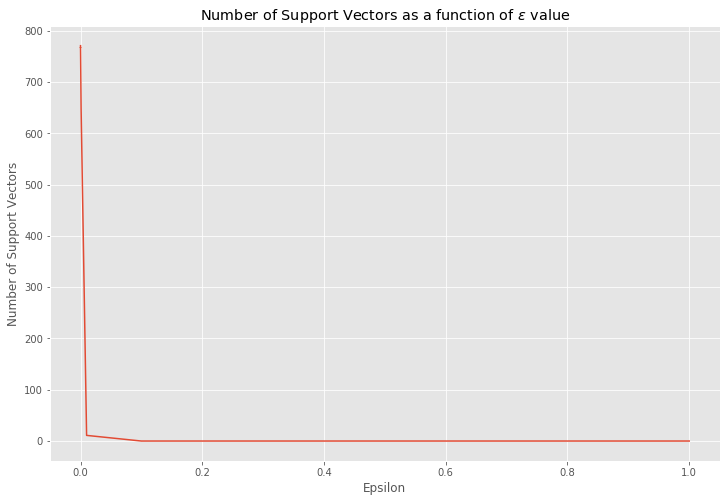

In [37]:
plt.plot(table['epsilon'].values, table['Number of SVs'].values)
plt.xlabel('Epsilon')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors as a function of $\epsilon$ value')
plt.savefig('nSVsepsilon.png')

In [40]:
data

Date     y_t+1       y_t     CAC40       DAX  DOWJONES   EURO100  \
1     2015-01-08  0.001280  0.006036  0.007133  0.005111  0.012180  0.006768   
2     2015-01-09 -0.008880  0.001280  0.035227  0.033009  0.018221  0.032502   
3     2015-01-13  0.000123 -0.008880 -0.019225 -0.019410 -0.009567 -0.016052   
4     2015-01-14 -0.005860  0.000123  0.026263  0.029865 -0.006998  0.025048   
5     2015-01-15  0.006615 -0.005860 -0.015749 -0.012544 -0.010650 -0.013758   
...          ...       ...       ...       ...       ...       ...       ...   
1108  2019-12-17 -0.000193  0.002091  0.012198  0.009362  0.003566  0.012200   
1109  2019-12-18  0.002190 -0.000193 -0.003913 -0.008978  0.001107 -0.004774   
1110  2019-12-19 -0.000567  0.002190 -0.001452 -0.004954 -0.000987 -0.000526   
1111  2019-12-20 -0.001817 -0.000567  0.002125 -0.000772  0.004864  0.002339   
1112  2019-12-23  0.007977 -0.001817  0.008213  0.008062  0.002749  0.008390   

      NIKKEI225     SP500       VIX      GOLD       OIL    SILVER    EURCHF  \
1      0.000127  0.000127  0.000127 -0.007161  0.014910 -0.005617 -0.000358   
2      0.016550  0.016550  0.016550 -0.001819  0.002874 -0.009677  0.000000   
3      0.001783  0.001783  0.001783  0.006270 -0.008852  0.002138  0.000025   
4     -0.006418 -0.006418 -0.006418  0.001297 -0.003915  0.035060 -0.000175   
5     -0.017221 -0.017221 -0.017221  0.000081  0.054904 -0.009918  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
1108  -0.002949 -0.002949 -0.002949 -0.000407  0.002328  0.006307 -0.006638   
1109   0.004739  0.004739  0.004739 -0.000271  0.012051 -0.002412  0.000438   
1110  -0.005487 -0.005487 -0.005487 -0.001357 -0.000164 -0.001474 -0.002084   
1111  -0.002911 -0.002911 -0.002911  0.003796  0.004748  0.006175 -0.003052   
1112  -0.002023 -0.002023 -0.002023 -0.002371 -0.012823  0.004095 -0.001185   

        EURGBP    EURUSD    GBPUSD    USDJPY  
1     0.002604 -0.005346 -0.007918 -0.006317  
2    -0.001454 -0.003320 -0.002011  0.005177  
3    -0.002134 -0.003379 -0.001299  0.004208  
4    -0.002139 -0.003306 -0.001260  0.000981  
5    -0.004498 -0.004509  0.000000 -0.004515  
...        ...       ...       ...       ...  
1108  0.003596 -0.005522 -0.009095 -0.000119  
1109  0.007201  0.001124 -0.006070  0.001607  
1110  0.012719  0.001293 -0.011390 -0.000548  
1111 -0.000577 -0.003184 -0.002660  0.000320  
1112  0.006104  0.000901 -0.005352 -0.001535  

[1111 rows x 18 columns]

In [ ]:
train_set = 0.70
k = int(train_set * len(y))
for i in range()
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    

In [16]:
epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
SVs = []
for epsilon in epsilons:
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    SV = model.support_vectors_
    SVs.append(SV)

In [30]:
epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
n_SVs = []
for epsilon in epsilons:
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    n_SV = model.support_
    n_SVs.append(n_SV)

In [31]:
n_SVs

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130,
        131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179

In [32]:
SVs[0].shape[0]

771

In [22]:
SVs[1].shape

(767, 16)

In [23]:
SVs[2].shape

(768, 16)

In [25]:
SVs[3].shape

(758, 16)

In [27]:
[n_svs for n_svs in ]

8

In [10]:
from sklearn.svm import SVR
C = 1
kernel = 'rbf'
train_set = 0.7
N = len(y)
k = int(train_set * N)
X_train = X[:k, :]
y_train = y[:k]

In [ ]:
psilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for epsilon in epsilons:

epsilon  Train CPU time (s)
0  1.000000e-07            0.345256
1  1.000000e-06            0.237603
2  1.000000e-05            0.270033
3  1.000000e-04            0.259068
4  1.000000e-03            0.193527
5  1.000000e-02            0.000947
6  1.000000e-01            0.000503
7  1.000000e+00            0.000467

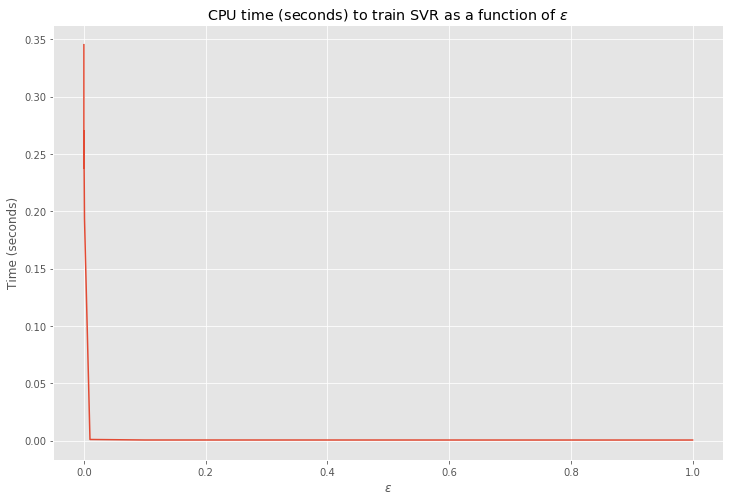

In [11]:
exec_time = []
import time
for epsilon in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    start_time = time.time()
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    ex_time = time.time() - start_time
    exec_time.extend((epsilon, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['epsilon', 'Train CPU time (s)'])
plt.plot(table['epsilon'].values, table['Train CPU time (s)'].values)
plt.xlabel('$\epsilon$')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of $\epsilon$')
plt.savefig('epsilon_cpu.png')
table

CPU Train time for C

C  Train CPU time (s)
0  1.000000e-07            0.002041
1  1.000000e-06            0.001391
2  1.000000e-05            0.001464
3  1.000000e-04            0.001277
4  1.000000e-03            0.000925
5  1.000000e-02            0.001529
6  1.000000e-01            0.001142
7  1.000000e+00            0.001020

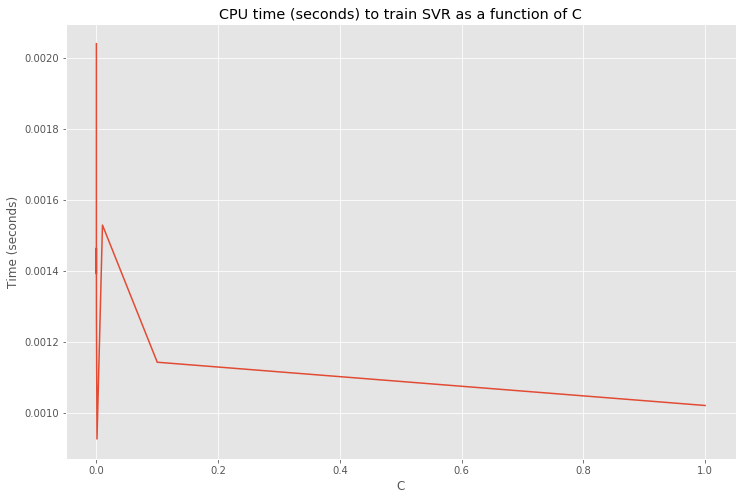

In [11]:
epsilon = 0.01
exec_time = []
import time
for C in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    start_time = time.time()
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    ex_time = time.time() - start_time
    exec_time.extend((C, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['C', 'Train CPU time (s)'])
plt.plot(table['C'].values, table['Train CPU time (s)'].values)
plt.xlabel('C')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of C')
plt.savefig('C_CPU.png')
table

Relationship between hyperparameters and test error

In [12]:
epsilon = 0.003
kernel = 'rbf'

4.824107017844845e-06
4.858461347455228e-06
4.827548027211785e-06
4.893783356588618e-06
4.948645784181495e-06
4.954163488565428e-06
4.969881008907349e-06
5.094871954646363e-06
5.053941885636192e-06
5.1099541276516685e-06
5.113352193456452e-06
5.235343531255345e-06
5.2561631264935145e-06
5.340006589520097e-06
5.348642629920268e-06
5.395307370051483e-06
5.44879066970906e-06
5.49172210651577e-06
5.499852768658277e-06
5.603618663021381e-06
5.538303815270808e-06
5.644975322820158e-06
5.623176659791907e-06
5.63949421144233e-06
5.676095711844556e-06
5.65082958595848e-06
5.726895717757321e-06
5.776518906659091e-06
5.8160773498574785e-06
5.859745949758396e-06
5.893082436811974e-06
5.900935631899223e-06
5.906524452464482e-06
6.01194170894638e-06
6.01005588035806e-06
6.06532495016801e-06
6.154455413127255e-06
6.111397797575189e-06
6.145674690436324e-06
6.252173287971515e-06
6.312260326851296e-06
6.269526926077456e-06
6.357238563244235e-06
6.370629953308832e-06
6.408150704531267e-06
6.385730205673

C  test errors
0   0.100000     0.000005
1   0.118367     0.000005
2   0.136735     0.000005
3   0.155102     0.000005
4   0.173469     0.000005
5   0.191837     0.000005
6   0.210204     0.000005
7   0.228571     0.000005
8   0.246939     0.000005
9   0.265306     0.000005
10  0.283673     0.000005
11  0.302041     0.000005
12  0.320408     0.000005
13  0.338776     0.000005
14  0.357143     0.000005
15  0.375510     0.000005
16  0.393878     0.000005
17  0.412245     0.000005
18  0.430612     0.000005
19  0.448980     0.000006
20  0.467347     0.000006
21  0.485714     0.000006
22  0.504082     0.000006
23  0.522449     0.000006
24  0.540816     0.000006
25  0.559184     0.000006
26  0.577551     0.000006
27  0.595918     0.000006
28  0.614286     0.000006
29  0.632653     0.000006
30  0.651020     0.000006
31  0.669388     0.000006
32  0.687755     0.000006
33  0.706122     0.000006
34  0.724490     0.000006
35  0.742857     0.000006
36  0.761224     0.000006
37  0.779592     0.000006
38  0.797959     0.000006
39  0.816327     0.000006
40  0.834694     0.000006
41  0.853061     0.000006
42  0.871429     0.000006
43  0.889796     0.000006
44  0.908163     0.000006
45  0.926531     0.000006
46  0.944898     0.000006
47  0.963265     0.000007
48  0.981633     0.000007
49  1.000000     0.000007

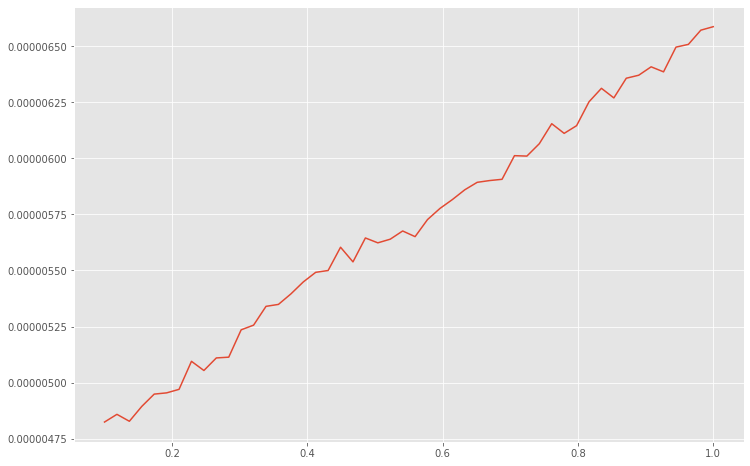

In [13]:
%%time
init_train_set = 0.75
results=[]
for C in list(np.linspace(0.1, 1)):
    y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C, kernel=kernel)
    test_error = epsilon_loss(y_true=y_true, y_pred=y_hat, epsilon=epsilon)
    print(test_error)
    results.extend((C, test_error))
    
results = np.array(results).reshape((-1, 2))
results = pd.DataFrame(results, columns=['C', 'test errors'])
plt.plot(results['C'].values, results['test errors'].values)
results    
    

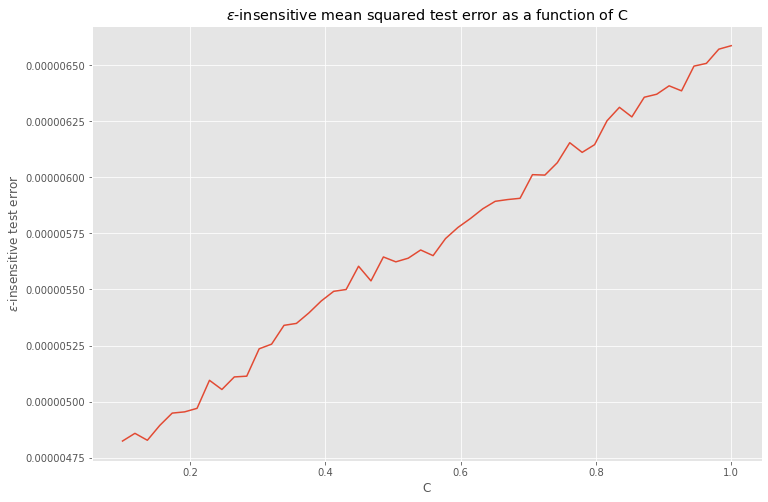

In [16]:
plt.plot(results['C'].values, results['test errors'].values)
plt.xlabel('C')
plt.ylabel('$\epsilon$-insensitive test error')
plt.title('$\epsilon$-insensitive mean squared test error as a function of C')
plt.savefig('epsilon_loss_C.png')

In [42]:
%%time
from sklearn.metrics import mean_absolute_error
C = 1
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3, 1e-2]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae)   

CPU times: user 3min 9s, sys: 871 ms, total: 3min 10s
Wall time: 3min 17s


[-54.891667878731134, -52.118891937389385, -50.90273910851027]

In [44]:
%%time
C = 0.1
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3, 1e-2]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae)   

CPU times: user 48.8 s, sys: 272 ms, total: 49.1 s
Wall time: 49.8 s


In [45]:
errors

[43.429011152004996, 43.34289853153337, 50.90273910851027]

In [46]:
%%time
C = 1
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3, 1e-2]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 

CPU times: user 3min 7s, sys: 782 ms, total: 3min 8s
Wall time: 3min 15s


In [47]:
errors

[54.891667878731134, 52.118891937389385, 50.90273910851027]

In [48]:
%%time
C = 10
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3, 1e-2]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 
errors

CPU times: user 9min 42s, sys: 2.11 s, total: 9min 44s
Wall time: 9min 58s


[70.50743480011815, 65.767959406896, 50.90273910851027]

In [49]:
%%time
C = 100
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3, 1e-2]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 
errors

CPU times: user 16min 40s, sys: 2.14 s, total: 16min 42s
Wall time: 16min 56s


[88.49076116050858, 72.5977303985001, 50.90273910851027]

In [50]:
%%time
C = 0.01
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 

CPU times: user 22.5 s, sys: 148 ms, total: 22.6 s
Wall time: 23.2 s


In [51]:
errors

[41.0350475089824, 40.98160569091459]

In [52]:
%%time
C = 0.001
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 

CPU times: user 16.6 s, sys: 33.8 ms, total: 16.6 s
Wall time: 16.7 s


In [53]:
errors

[41.016295372175705, 40.237054804159754]

In [54]:
%%time
C = 1e-10
kernel='rbf'
train_set = 0.75
epsilons = [1e-4, 1e-3]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 

CPU times: user 16.3 s, sys: 42.6 ms, total: 16.4 s
Wall time: 16.5 s


In [55]:
errors

[41.22421391005298, 41.45163237852043]

In [56]:
C = 1e-4
kernel='rbf'
train_set = 0.75
epsilons = [1e-10, 1e-9]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 

In [57]:
errors

[41.04113971583567, 41.04113971583567]

In [58]:
C = 0.5
kernel='rbf'
train_set = 0.75
epsilons = [1e-10, 1e-9]
y_mean = y.mean()
errors = []
for epsilon in epsilons:
    y_hat, y_true = ts_crossval(X=X, y=y, init_train_set=train_set, epsilon=epsilon, C=C, kernel=kernel)
    adj_mae = mean_absolute_error(y_hat, y_true) / abs(y_mean)
    errors.append(adj_mae) 
errors

[49.95146903408749, 50.16517577427771]

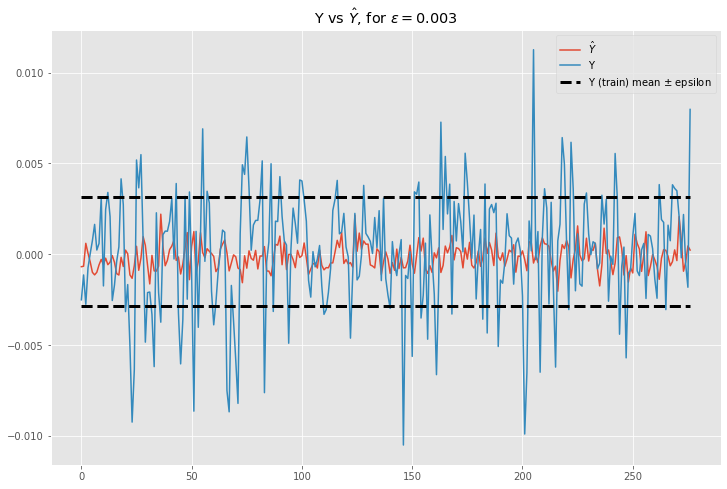

4.623889020799496e-06

In [111]:
epsilon = 0.003
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)


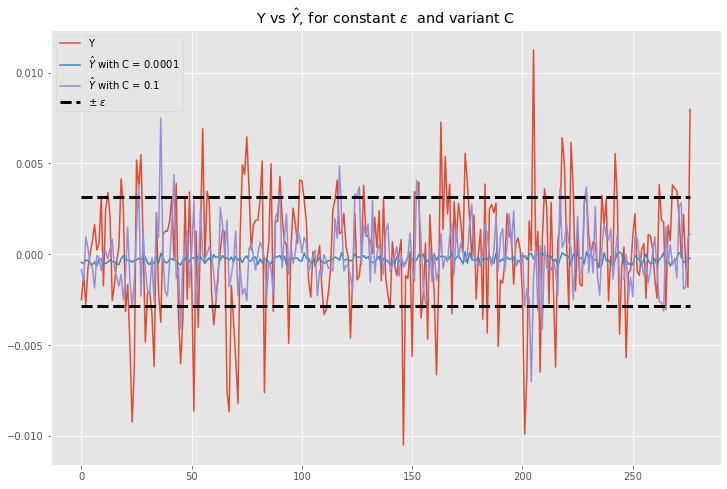

In [134]:
C_0 = 0.0001
C_1 = 0.1
epsilon = 0.003
y_hat1, y_true1 = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C_0, kernel=kernel)
y_hat2, y_true2 = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C_1, kernel=kernel)

plot_C_impact(y_true, y_preds=[y_hat1, y_hat2], C_values=[C_0, C_1], epsilon=epsilon)

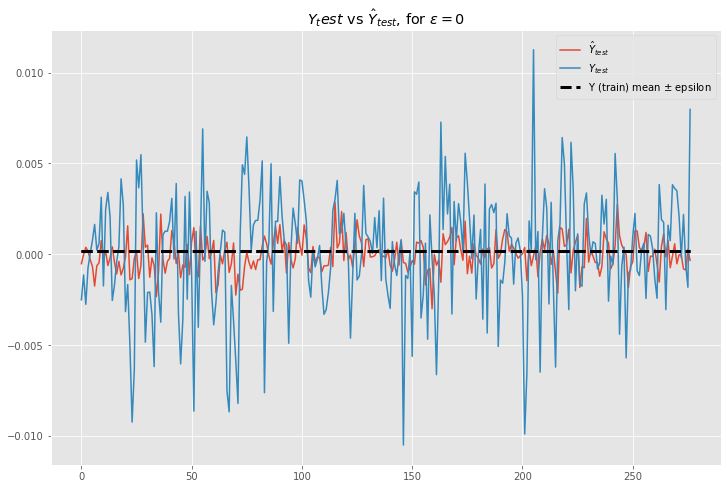

CPU times: user 11.3 s, sys: 99.6 ms, total: 11.4 s
Wall time: 11.6 s


1.103744877329773e-05

In [114]:
%%time
epsilon = 0
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)

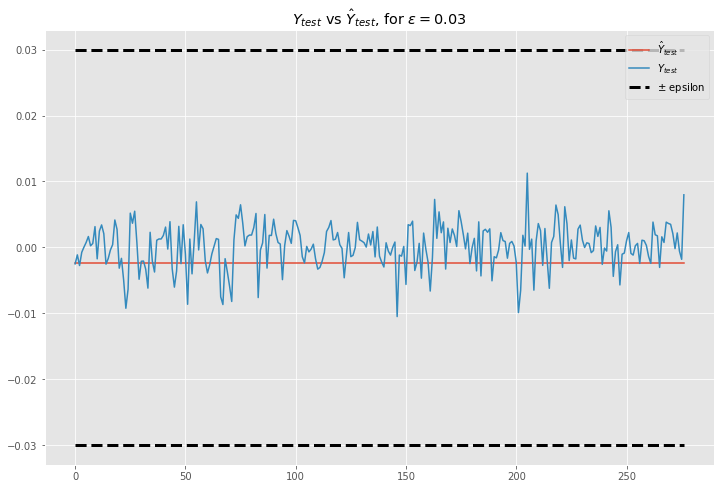

0.0007093623839748393

In [120]:
epsilon=0.03
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)

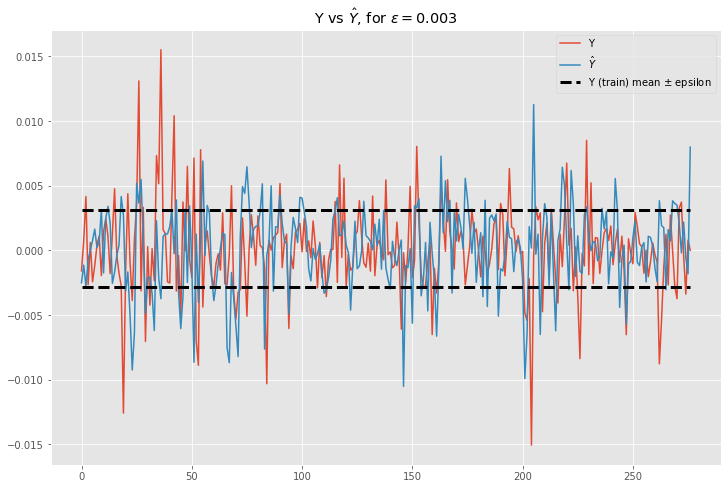

In [93]:
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=0.001, C=1, kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)

In [95]:
from sklearn.metrics import mean_squared_error

In [96]:
def RMSE(y_hat, y_true):
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_hat, y_true, squared=False)
    return rmse

def max_error(y_hat, y_true):
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_hat, y_true)
    max_err = np.max(mae)
    return max_err

In [97]:
RMSE(y_hat, y_true)

0.004432914679460218

In [102]:
def max_error(y_hat, y_true):
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_hat, y_true)
    max_err = np.max(mae)
    return max_err

In [103]:
max_error(y_hat, y_true)

0.003301945989452347

## Model selection

In [14]:
%%time
kernel = 'rbf'
init_train_set = 0.75
model = []
for epsilon in list(np.linspace(0, 0.09)):
    for C in list(np.linspace(0.01, 0.09)):
        y_pred, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C, kernel=kernel)
        test_error = epsilon_loss(y_pred, y_true, epsilon)
        model.extend((epsilon, C, test_error))

model = np.array(model).reshape((-1, 3))
model = pd.DataFrame(model, columns=['epsilon', 'C', 'test error'])      

CPU times: user 38min 33s, sys: 7.69 s, total: 38min 41s
Wall time: 39min 16s


In [15]:
model

epsilon         C  test error
0        0.00  0.010000    0.000011
1        0.00  0.011633    0.000011
2        0.00  0.013265    0.000011
3        0.00  0.014898    0.000011
4        0.00  0.016531    0.000011
...       ...       ...         ...
2495     0.09  0.083469    0.007494
2496     0.09  0.085102    0.007494
2497     0.09  0.086735    0.007494
2498     0.09  0.088367    0.007494
2499     0.09  0.090000    0.007494

[2500 rows x 3 columns]

In [17]:
np.argmin(model['test error'])

50

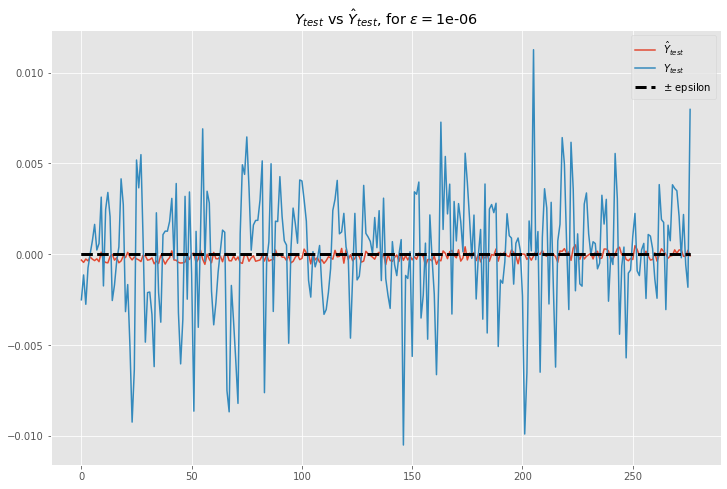

Epsilon error: 1.059315462344784e-05  Adj. RMSE: 21.110099345669347


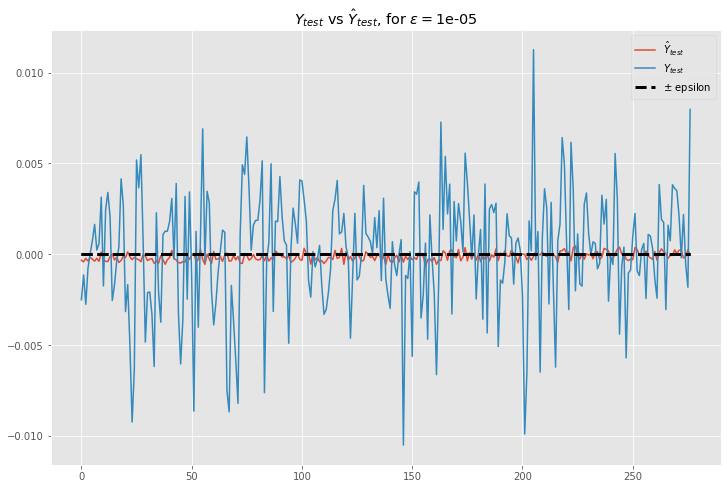

Epsilon error: 1.0532846469714326e-05  Adj. RMSE: 21.095265377420905


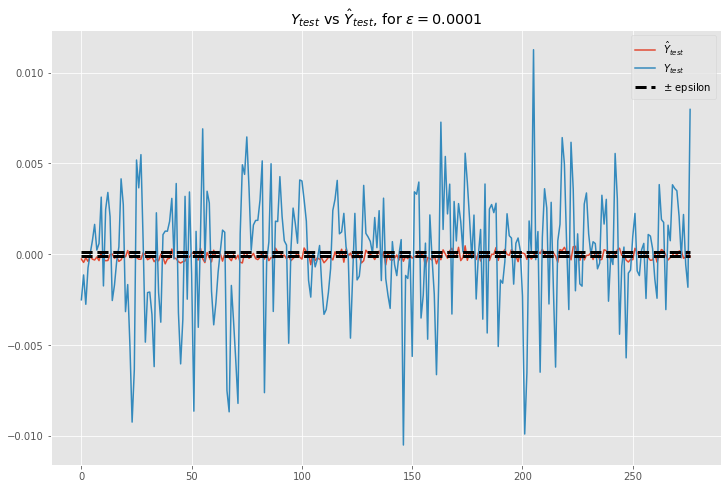

Epsilon error: 1.0082834954155064e-05  Adj. RMSE: 21.08835089006987


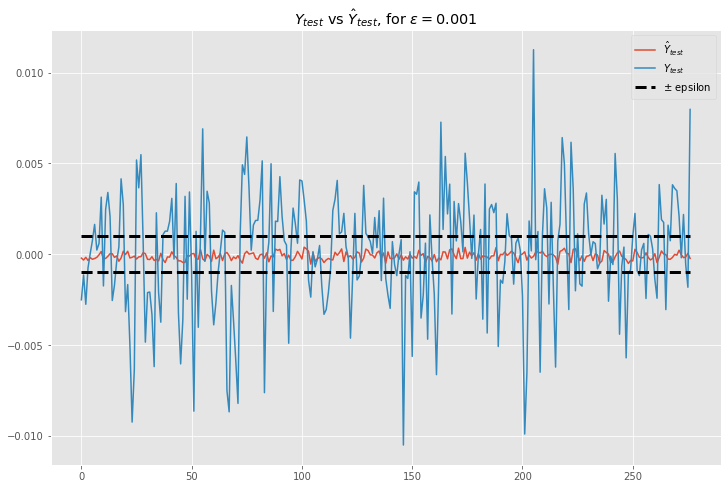

Epsilon error: 6.545860041519443e-06  Adj. RMSE: 21.0810328501937


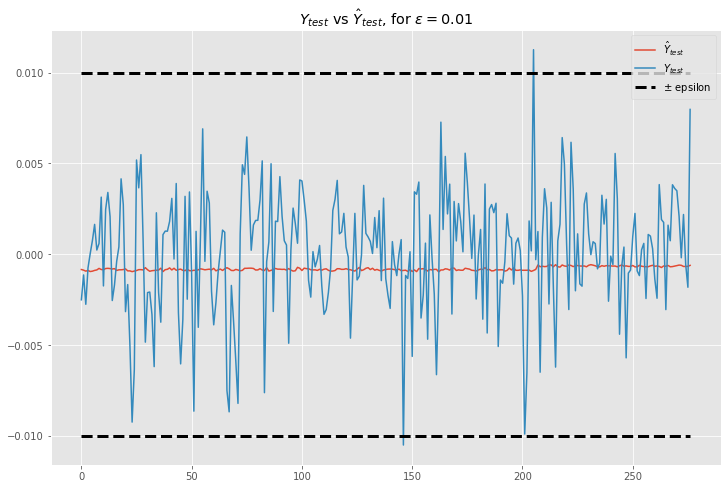

Epsilon error: 5.737811620685163e-05  Adj. RMSE: 21.976506515583203
CPU times: user 42.5 s, sys: 462 ms, total: 42.9 s
Wall time: 52.5 s


In [12]:
%%time
C = 0.0001
for epsilon in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    y_pred, y_true = ts_crossval(X, y, init_train_set=0.75, epsilon=epsilon, C=C, kernel='rbf')
    plot_predictions(y_true, y_pred, epsilon)
    adj_rmse = RMSE(y_true, y_pred) / np.mean(y_true)
    epsilon_error = epsilon_loss(y_true, y_pred, epsilon)
    print('Epsilon error: ' + str(epsilon_error), ' Adj. RMSE: ' + str(adj_rmse)) 
    

In [ ]:
%%time
C = 10
for epsilon in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    y_pred, y_true = ts_crossval(X, y, init_train_set=0.75, epsilon=epsilon, C=C, kernel='rbf')
    plot_predictions(y_true, y_pred, epsilon)
    adj_rmse = RMSE(y_true, y_pred) / np.mean(y_true)
    epsilon_error = epsilon_loss(y_true, y_pred, epsilon)
    print('Epsilon error: ' + str(epsilon_error), ' Adj. RMSE: ' + str(adj_rmse)) 

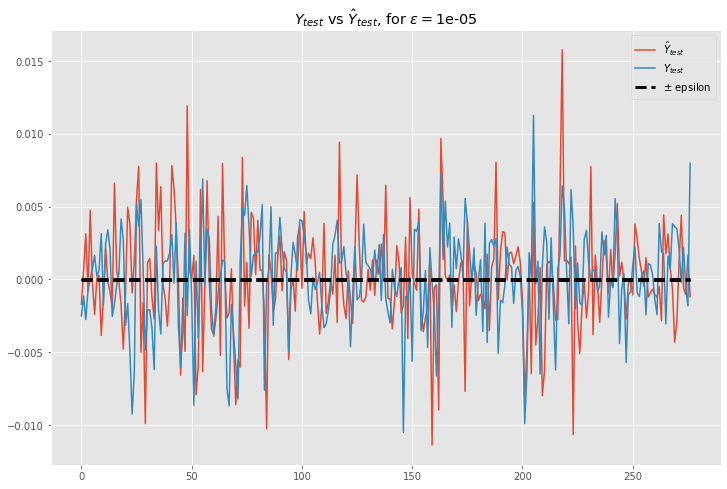

Epsilon error: 1.9087628201336286e-05  Adj. RMSE: 28.38047774912303


In [9]:
epsilon = 1e-5
C = 1
y_pred, y_true = ts_crossval(X, y, init_train_set=0.75, epsilon=epsilon, C=C, kernel='rbf')
plot_predictions(y_true, y_pred, epsilon)
adj_rmse = RMSE(y_true, y_pred) / np.mean(y_true)
epsilon_error = epsilon_loss(y_true, y_pred, epsilon)
print('Epsilon error: ' + str(epsilon_error), ' Adj. RMSE: ' + str(adj_rmse)) 

In [29]:
test_errors

[1e-05,
 1.1866194691531681e-05,
 0.0001,
 1.1360667033272397e-05,
 0.001,
 7.453686260176828e-06,
 0.01,
 5.1563027862307047e-05]

CPU times: user 1min 12s, sys: 161 ms, total: 1min 13s
Wall time: 1min 13s


Text(0.5, 1.0, '$\\epsilon$-sensitive test error as a function of $\\epsilon$')

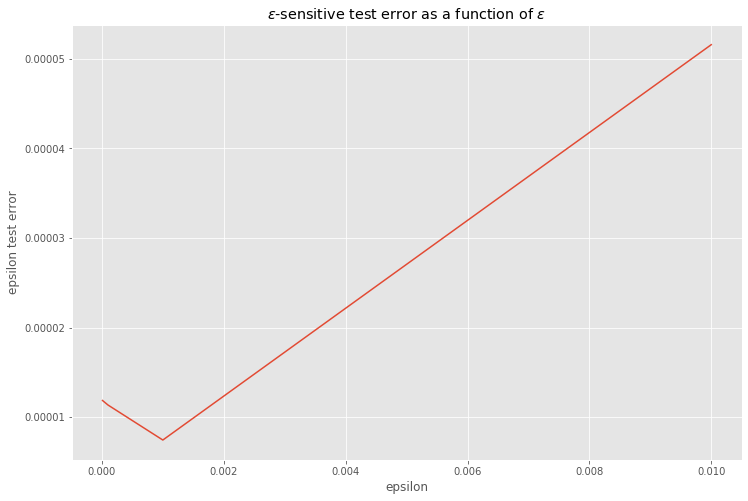

In [31]:
C = 0.1
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
errors = []
for epsilon in epsilons:
    y_true, y_pred = ts_crossval(X, y, init_train_set=0.75, epsilon=epsilon, C=C, kernel='rbf')
    error = epsilon_loss(y_true, y_pred, epsilon)
    errors.extend((epsilon, error))
    
errors = np.array(errors).reshape((-1, 2))
errors = pd.DataFrame(errors, columns=['epsilon', 'epsilon test error'])
plt.plot(errors['epsilon'].values, errors['epsilon test error'].values)
plt.xlabel('epsilon')
plt.ylabel('epsilon test error')
plt.title('$\epsilon$-sensitive test error as a function of $\epsilon$')

Text(0.5, 1.0, '$\\epsilon$-sensitive train error as a function of $\\epsilon$')

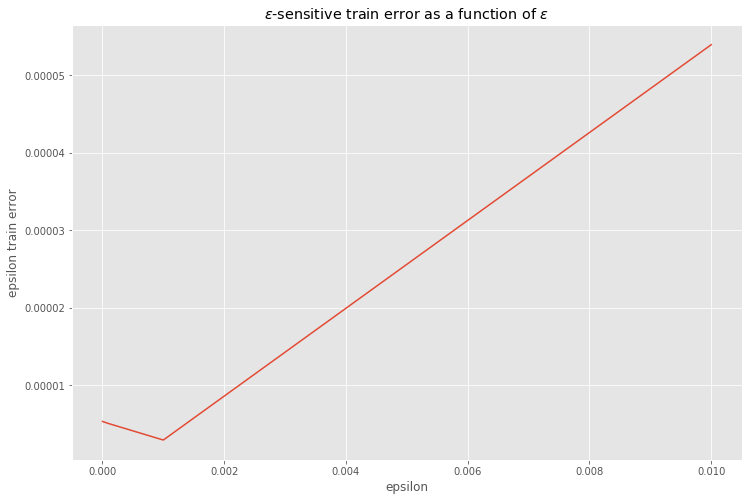

In [41]:
from sklearn.svm import SVR 
C = 0.05
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
errors = []
for epsilon in epsilons:
    model = SVR(epsilon=epsilon, C=C, kernel='rbf').fit(X, y)
    y_hat = model.predict(X)
    error = epsilon_loss(y, y_hat, epsilon)
    errors.extend((epsilon, error))
    
errors = np.array(errors).reshape((-1, 2))
errors = pd.DataFrame(errors, columns=['epsilon', 'epsilon test error'])
plt.plot(errors['epsilon'].values, errors['epsilon test error'].values)
plt.xlabel('epsilon')
plt.ylabel('epsilon train error')
plt.title('$\epsilon$-sensitive train error as a function of $\epsilon$')

In [36]:
y_pred = model.predict(X)
train_error = epsilon_loss(y_pred, y, epsilon)

In [ ]:
C = 0.1
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
errors = []
for epsilon in epsilons:
    y_true, y_pred = ts_crossval(X, y, init_train_set=0.75, epsilon=epsilon, C=C, kernel='rbf')
    error = epsilon_loss(y_true, y_pred, epsilon)
    errors.extend((epsilon, error))
    
errors = np.array(errors).reshape((-1, 2))
errors = pd.DataFrame(errors, columns=['epsilon', 'epsilon test error'])
plt.plot(errors['epsilon'].values, errors['epsilon test error'].values)
plt.xlabel('epsilon')
plt.ylabel('epsilon test error')
plt.title('$\epsilon$-sensitive test error as a function of $\epsilon$')

Text(0.5, 1.0, '$\\epsilon$-sensitive test error as a function of $\\epsilon$')

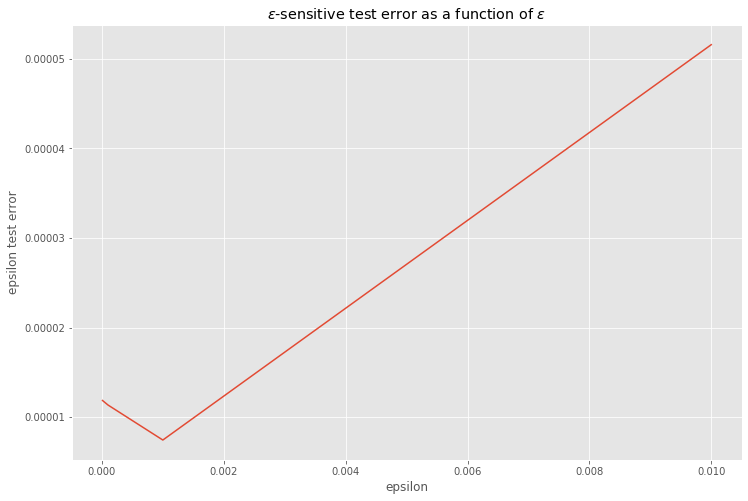

In [30]:
errors = np.array(test_errors).reshape((-1, 2))
errors = pd.DataFrame(errors, columns=['epsilon', 'epsilon test error'])
plt.plot(errors['epsilon'].values, errors['epsilon test error'].values)
plt.xlabel('epsilon')
plt.ylabel('epsilon test error')
plt.title('$\epsilon$-sensitive test error as a function of $\epsilon$') 

Text(0.5, 1.0, '$\\epsilon$-sensitive test error as a function of $\\epsilon$')

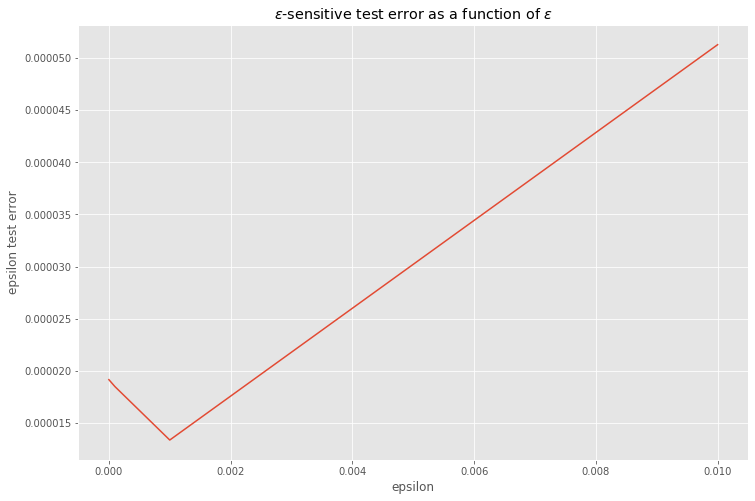

In [26]:
epsilons = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
errors = []
for epsilon in epsilons:
    error = epsilon_loss(y_true, y_pred, epsilon)
    errors.extend((epsilon, error))
    
errors = np.array(errors).reshape((-1, 2))
errors = pd.DataFrame(errors, columns=['epsilon', 'epsilon test error'])
plt.plot(errors['epsilon'].values, errors['epsilon test error'].values)
plt.xlabel('epsilon')
plt.ylabel('epsilon test error')
plt.title('$\epsilon$-sensitive test error as a function of $\epsilon$')

In [23]:
epsilon_loss(y_true, y_pred, epsilon=1e-10)

1.9155413010343558e-05

In [14]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred)/y_true.mean()

22.010042538847756

In [26]:
epsilon_star = model['epsilon'].loc[model['test error'] == np.min(model['test error'])].values[0]
C_star = model['C'].loc[model['test error'] == np.min(model['test error'])].values[0]

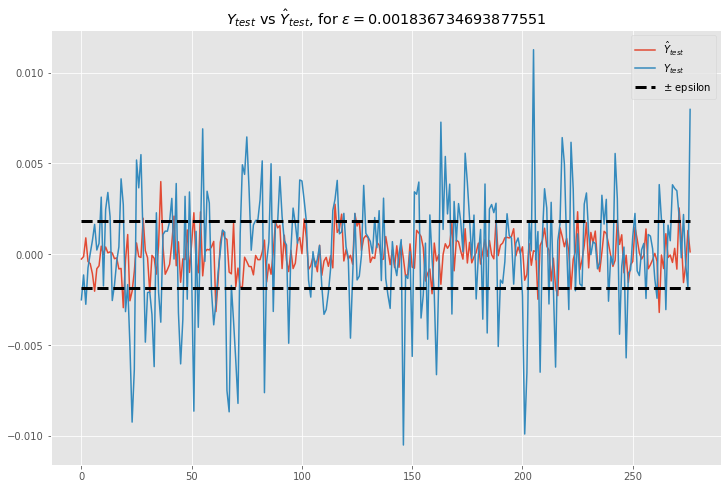

In [28]:
y_pred, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon_star, C=C_star, kernel='rbf')
plot_predictions(y_true, y_pred, epsilon_star)

In [38]:
RMSE(y_pred, y_true)/y_true.mean()

21.70138677944264

In [32]:
RMSE(y_pred, y_true)

0.0033466751057095894

In [35]:
max_error(y_pred, y_true)/np.mean(y_true)

16.519728164394607

In [34]:
np.mean(y_true)

0.00015421480386128313

In [12]:
kernel = 'rbf'
init_train_set = 0.75
upper_bound = np.abs(np.mean(y))
epsilons = np.linspace(upper_bound/10, upper_bound, 5)
C_s = np.linspace(np.std(y)/10, np.std(y))
epsilon = epsilons[0]
C = C_s[0]

In [13]:
%%time
y_pred, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C, kernel=kernel)
test_epsilon_error = epsilon_loss(y_pred, y_true, epsilon)
rmse = RMSE(y_pred, y_true)
adj_rmse = rmse/np.mean(y_true)

CPU times: user 10.5 s, sys: 78.1 ms, total: 10.6 s
Wall time: 10.9 s


In [14]:
adj_rmse

21.215225281585756

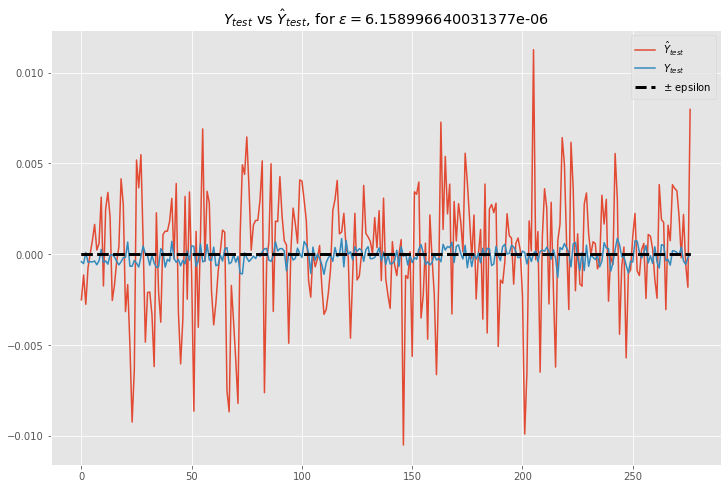

In [16]:
plot_predictions(y_true, y_pred, epsilon)

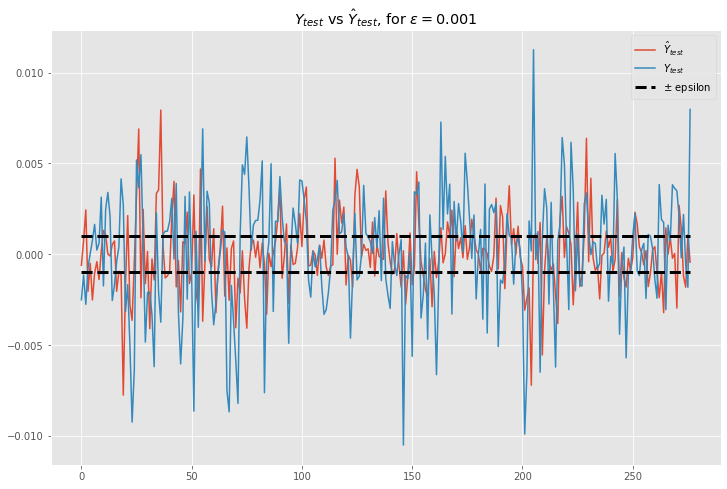

CPU times: user 23.7 s, sys: 223 ms, total: 23.9 s
Wall time: 30.1 s


In [18]:
%%time
y_pred, y_true = ts_crossval(X, y, init_train_set, epsilon=0.001, C=0.1, kernel=kernel)
test_epsilon_error = epsilon_loss(y_pred, y_true, 0.001)
rmse = RMSE(y_pred, y_true)
adj_rmse = rmse/np.mean(y_true)
plot_predictions(y_true, y_pred, 0.001)

In [10]:
def epsilon_loss(y_true, y_pred, epsilon):
    error = np.abs(y_true - y_pred) - epsilon
    squared_errors = [x**2 for x in error]
    return np.mean(squared_errors)

In [11]:
def SVR_proba_error(X, y, init_train_set, epsilon, C):
    from sklearn.svm import SVR
    
    errors = []
    init_train_point = int(init_train_set*len(y))
    
    for i in range(init_train_point, len(y)-1):
        X_train = X[:i,:]
        y_train = y[:i]
        model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
        X_test = X[i+1,:].reshape(1,-1)
        y_test = y[i+1]
        y_pred = model.predict(X_test)
        error = np.abs(y_test - y_pred) - epsilon
        errors.append(error)
    
    M = len(errors)
    sigma_gauss = 1/M * np.sum([error**2 for error in errors])
    sigma_lp = 1/M * np.sum([np.abs(error) for error in errors])
    
    return errors, sigma_gauss, sigma_lp
    

In [31]:
%%time
errors, sigma_g, sigma_l = SVR_proba_error(X, y, init_train_set=0.9, epsilon=0.001, C=1)
np.mean(errors)

CPU times: user 29.4 s, sys: 81.6 ms, total: 29.5 s
Wall time: 29.6 s


0.0022048687988307316

In [42]:
def ts_crossval(X, y, init_train_set, epsilon, C, kernel):
    """
    Inputs: 
    - Features array X
    - Target vector y
    - Percentage of dataset dedicated to initial train set (init_train_set)
    - Hyperparameters of SVR algorithm: C and epsilon
    - Kernel function to use (string)
    
    Output:
    - y_pred: the estimated target vector of the algorithm
    - y_test: the actual target vector that was aimed at predicting by y_pred
    """
    from sklearn.svm import SVR
    
    N = len(y)
    init_train_point = int(init_train_set * N)
    predictions=[]
    y_true = []
    for i in range(init_train_point, len(X)-1):
        X_train = X[:i, :]
        y_train = y[:i]
        model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
        X_test = X[i+1, :].reshape(1,-1)
        y_test = y[i+1]
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        y_true.append(y_test)
    
    
    return predictions, y_true

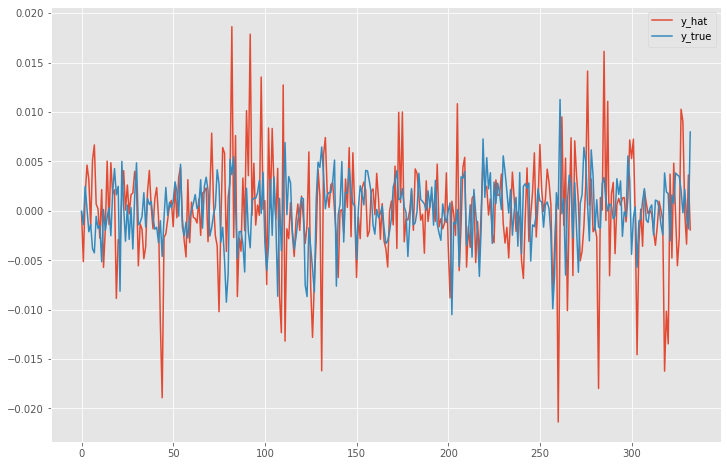

In [57]:
error, y_hat, y_true = ts_crossval(X, y, 0.7, epsilon=0.001, C=10, kernel='rbf')
x = np.arange(0, len(y_true))
plt.plot(x, y_hat)
plt.plot(x, y_true)
plt.legend(['y_hat', 'y_true'])

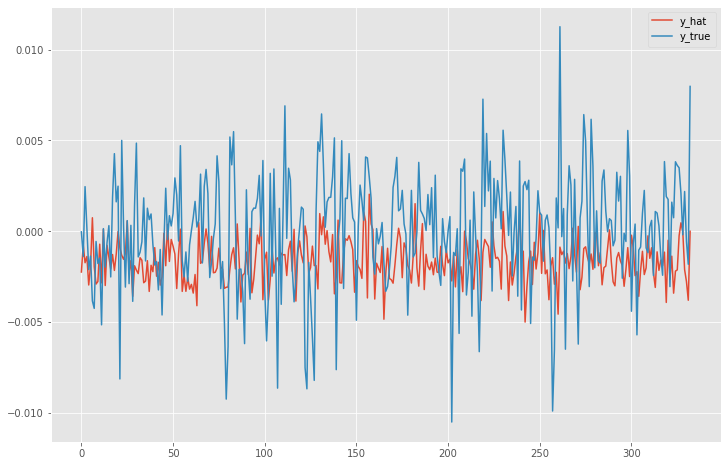

In [59]:
error, y_hat, y_true = ts_crossval(X, y, 0.7, epsilon=0.01, C=10, kernel='rbf')
x = np.arange(0, len(y_true))
plt.plot(x, y_hat)
plt.plot(x, y_true)
plt.legend(['y_hat', 'y_true'])

In [51]:
len(y_true)

333

In [39]:
ts_crossval(X, y, 0.7, epsilon=0.1, C=1, kernel='rbf')

0.009350909445832317

In [13]:
def plot_predictions(X, y, train_set, epsilon, C):
    
    plt.rcParams['figure.figsize']=(12,8)
    plt.style.use('ggplot')
    from sklearn.svm import SVR
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
    X_test = X[k+1:,:]
    y_test = y[k+1:].reshape(-1,1)
    y_pred = model.predict(X_test).reshape(-1,1)
    n = len(y_pred)
    x = np.arange(0,n, 1)
    plt.plot(x, y_pred)
    plt.plot(x, y_test)
    plt.plot(x, [y_train.mean() + y_train.std()]*n, '--', linewidth=3, color='black')
    plt.plot(x, [y_train.mean() - y_train.std()]*n, '--', linewidth=3, color='black')
    plt.title('Y vs $\hat{Y}$, for $\epsilon = $' + str(epsilon))
    plt.legend(['Y', '$\hat{Y}$', 'Y (train) mean $\pm$ std'])
    plt.show()


In [30]:
def plot_C(X,y,train_set, epsilon, C_values):
    
    plt.rcParams['figure.figsize']=(12,8)
    plt.style.use('ggplot')
    from sklearn.svm import SVR
    
    C_0, C_1 = C_values
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model1 = SVR(epsilon=epsilon, C=C_0).fit(X_train, y_train)
    model2 = SVR(epsilon=epsilon, C=C_1).fit(X_train, y_train)
    X_test = X[k+1:,:]
    y_test = y[k+1:].reshape(-1,1)
    y_pred1 = model1.predict(X_test).reshape(-1,1)
    y_pred2 = model2.predict(X_test).reshape(-1,1)
    n = len(y_pred1)
    x = np.arange(0,n,1)
    plt.plot(x, y_test)
    plt.plot(x, y_pred1)
    plt.plot(x, y_pred2)
    plt.plot(x, [y_train.mean() + epsilon]*n, '--', linewidth=3, color='black')
    plt.plot(x, [y_train.mean() - epsilon]*n, '--', linewidth=3, color='black')
    plt.title('Y vs $\hat{Y}$, for constant $\epsilon$  and variant C')
    plt.legend(['Y', '$\hat{Y}$ with C = $C_0$', '$\hat{Y}$ with C = $C_1$', 'Y (train) mean $\pm$ $\epsilon$'])
    
    
    
    
    
    
    

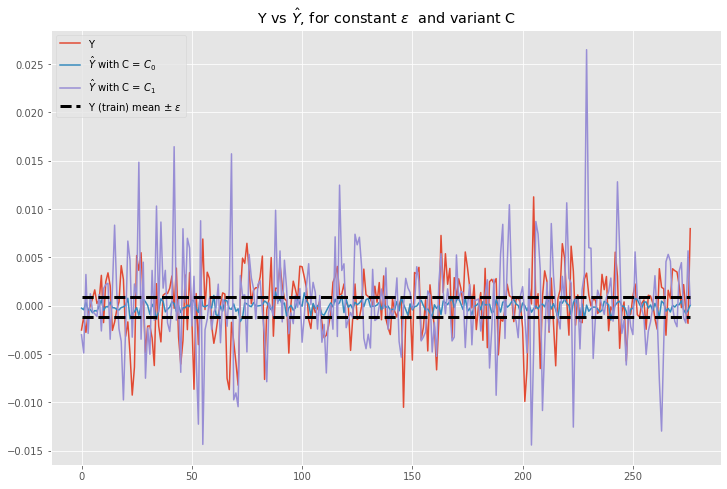

In [31]:
plot_C(X, y, 0.75, epsilon=0.001, C_values=[0.001, 10])

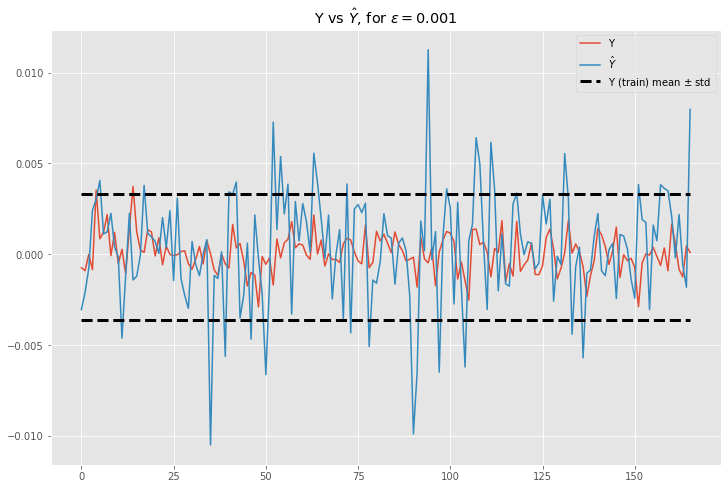

In [19]:
plot_predictions(X, y, 0.85, epsilon=0.001, C=0.01)

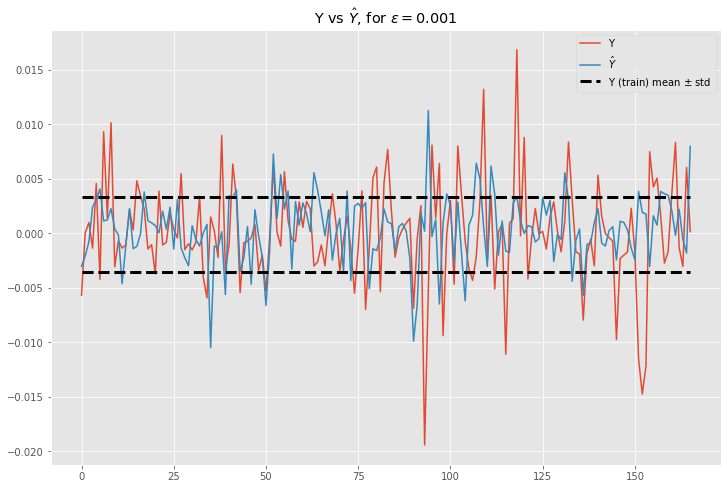

In [29]:
plot_predictions(X, y, 0.85, epsilon=0.001, C=10)

epsilon: 0.1 $Epsilon loss: 0.009268563864804466


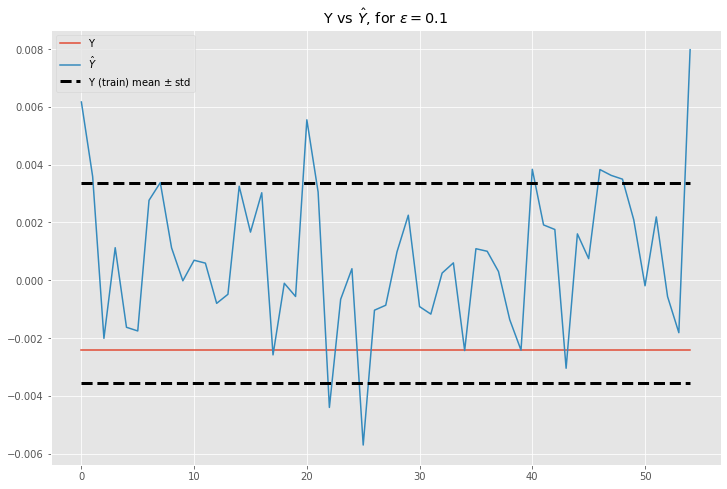

epsilon: 0.01 $Epsilon loss: 5.1542134130705426e-05


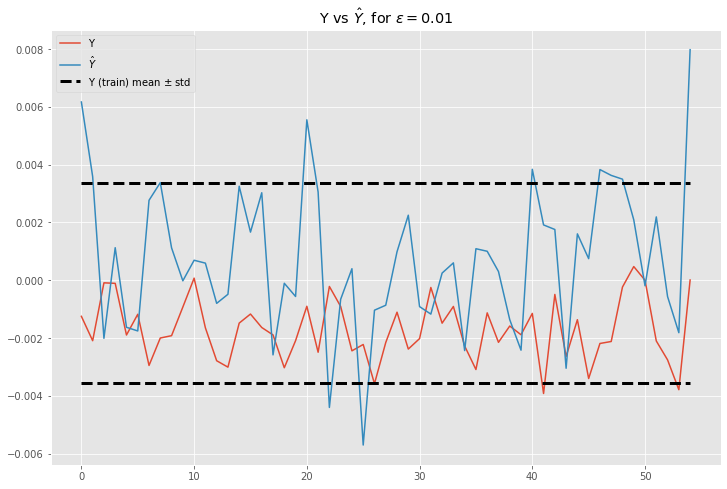

epsilon: 0.001 $Epsilon loss: 1.4004309347818422e-05


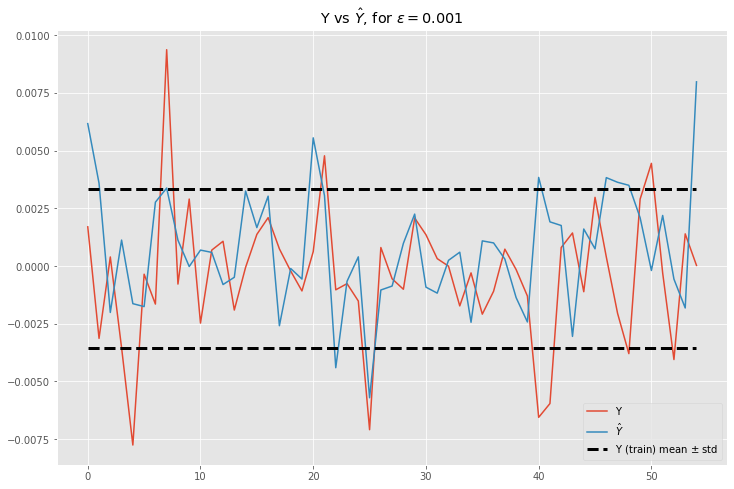

epsilon: 0.0001 $Epsilon loss: 2.1981300155869698e-05


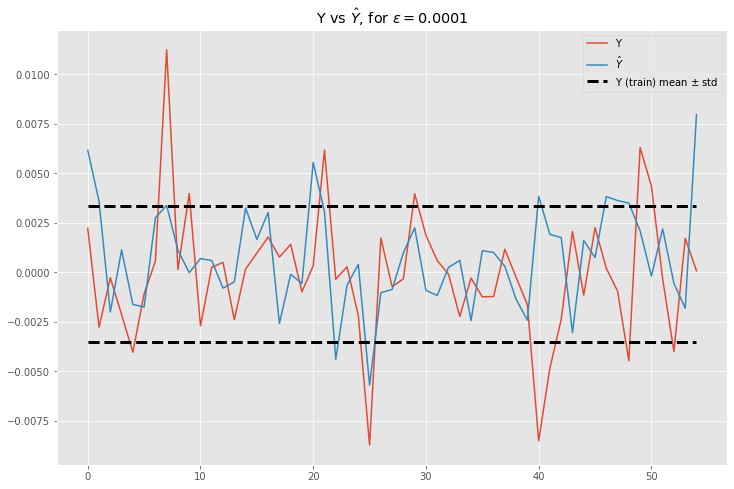

epsilon: 1e-05 $Epsilon loss: 2.34690389476303e-05


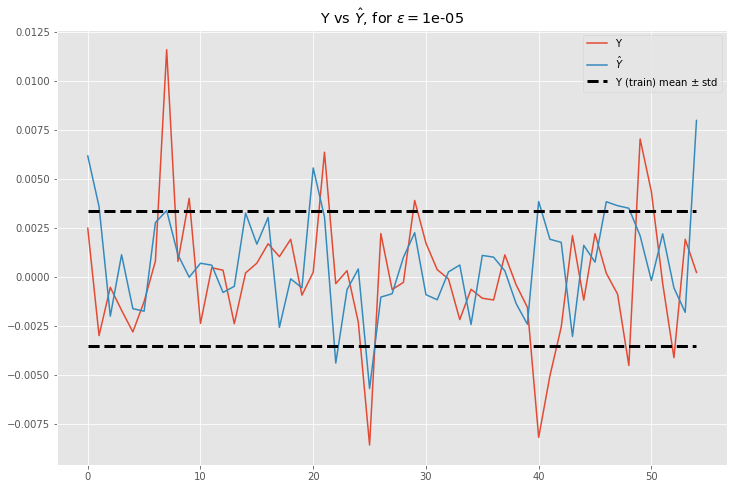

CPU times: user 1min 17s, sys: 446 ms, total: 1min 18s
Wall time: 1min 19s


In [47]:
%%time
upper_bound = y.std()
#n_epsilons = 5
#epsilons = list(np.linspace(0, upper_bound, n_epsilons))
epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001]
from sklearn.svm import SVR

for epsilon in epsilons:
    epsilon_error = ts_crossval(X,y,init_train_set=0.95, algo=SVR(epsilon=epsilon, C=1, kernel='rbf'), epsilon=epsilon)
    print('epsilon: ' + str(epsilon), '$Epsilon loss: ' + str(epsilon_error))
    plot_predictions( X, y, train_set=0.95, epsilon=epsilon, C=1)

epsilon: 0.1 RMSE: 0.004524078370634977


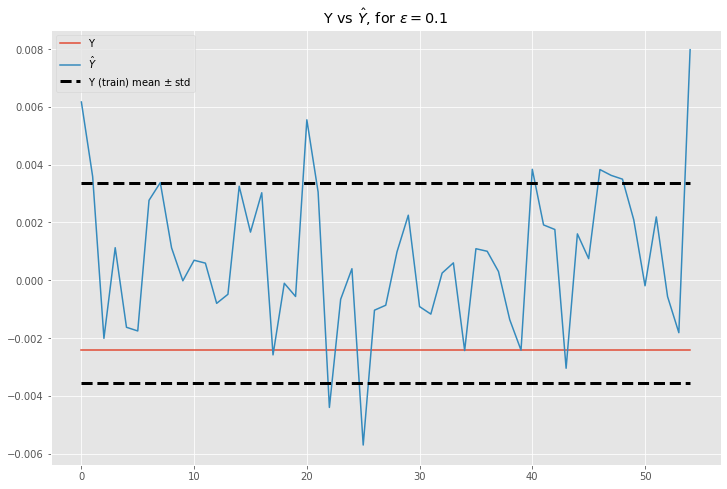

epsilon: 0.01 RMSE: 9.944387748137329


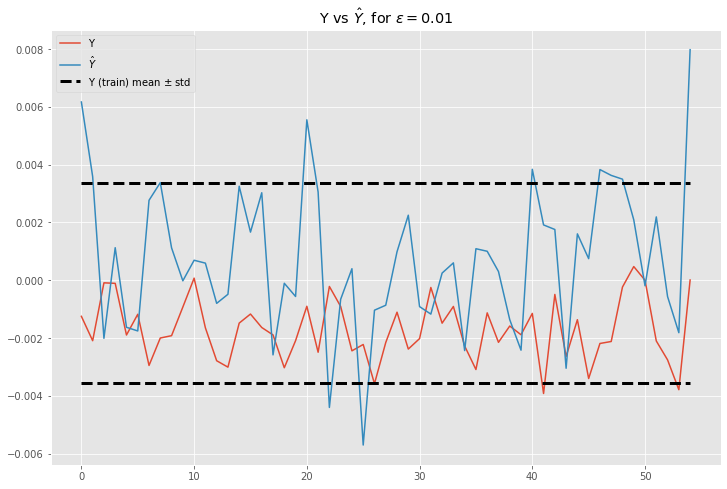

CPU times: user 4.83 s, sys: 77 ms, total: 4.91 s
Wall time: 5.06 s


In [15]:
%%time
upper_bound = y.std()
#n_epsilons = 5
#epsilons = list(np.linspace(0, upper_bound, n_epsilons))
#epsilons = [0.1, 0.01, 0.001, 0.0001, 0.00001]
epsilons = [0.1, 0.01]
from sklearn.svm import SVR

for epsilon in epsilons:
    rmse = ts_crossval(X,y,init_train_set=0.95, algo=SVR(epsilon=epsilon, C=1, kernel='sigmoid'))
    print('epsilon: ' + str(epsilon), 'RMSE: ' + str(rmse))
    plot_predictions( X, y, train_set=0.95, epsilon=epsilon, C=1)

epsilon: 0.003416079893089063 RMSE: 0.003907888978944097


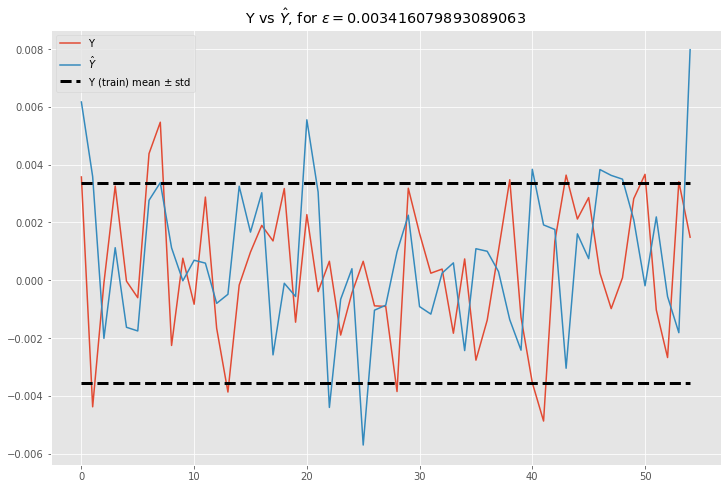

epsilon: 0.003416079893089063 RMSE: 0.003906709283376968


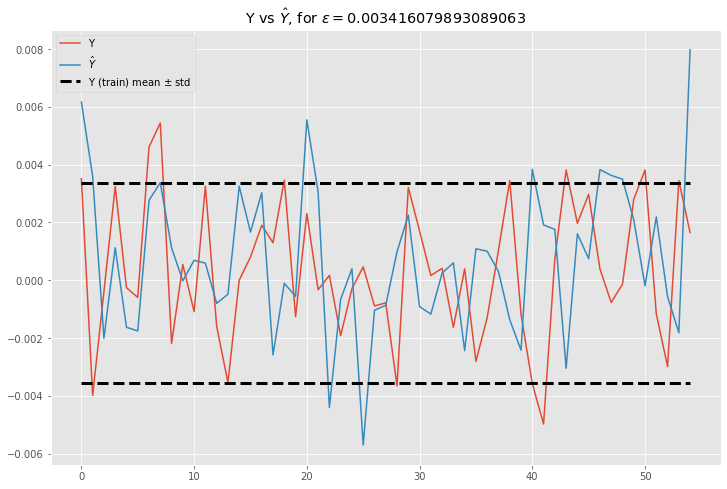

epsilon: 0.003416079893089063 RMSE: 0.003816690275782753


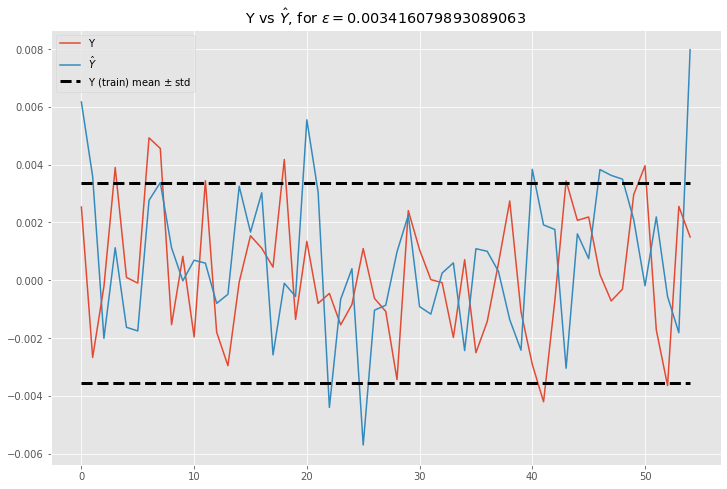

epsilon: 0.003416079893089063 RMSE: 0.0037570593057035663


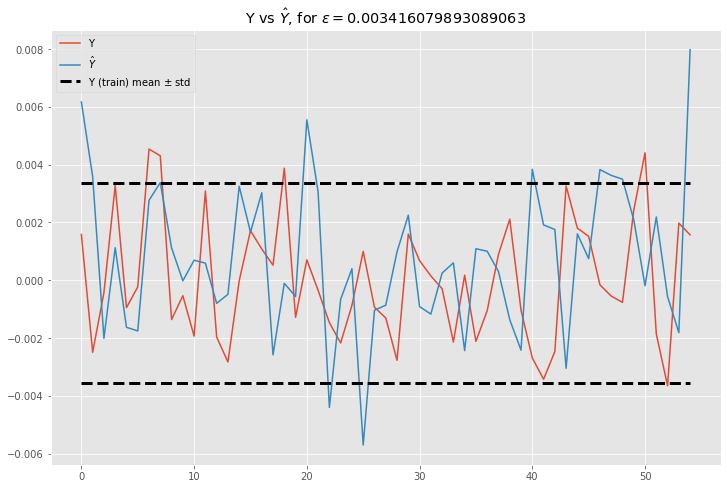

epsilon: 0.003416079893089063 RMSE: 0.003530737658977363


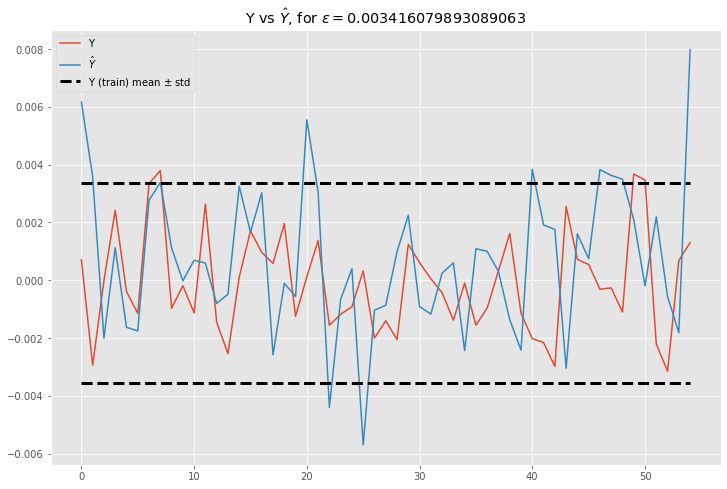

epsilon: 0.003416079893089063 RMSE: 0.0033423854836852744


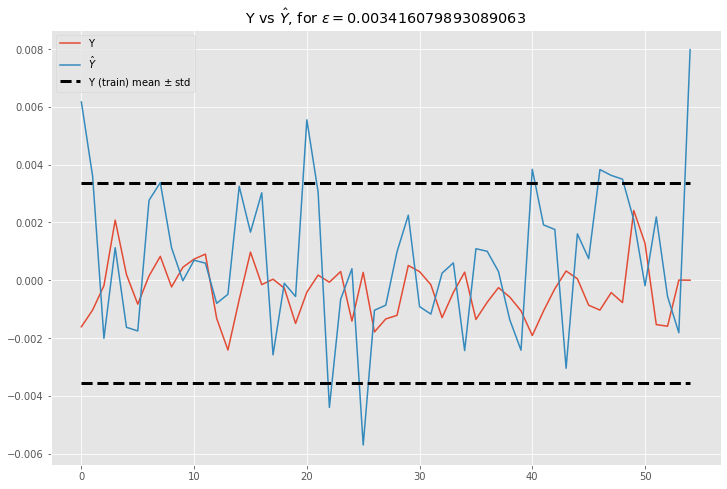

CPU times: user 15.7 s, sys: 92.2 ms, total: 15.7 s
Wall time: 15.8 s


In [103]:
%%time
upper_bound = y.std()
epsilon = upper_bound
#n_epsilons = 5
#epsilons = list(np.linspace(0, upper_bound, n_epsilons))
C_ = [10, 1, 0.5, 0.25, 0.1, 0.01]
from sklearn.svm import SVR

for C in C_:
    rmse = ts_crossval(X,y,init_train_set=0.95, algo=SVR(epsilon=epsilon, C=C))
    print('epsilon: ' + str(epsilon), 'RMSE: ' + str(rmse))
    plot_predictions( X, y, train_set=0.95, epsilon=epsilon, C=C)

In [107]:
len(y)

1111

In [114]:
from sklearn.svm import SVR
N = len(y)
k = int(train_set*N)
X_train = X[:k,:]
y_train = y[:k]
model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
X_test = X[k:,:]
y_test = y[k:].reshape(-1,1)
y_pred1 = model.predict(X_train).reshape(-1,1)
y_pred2 = model.predict(X_test).reshape(-1,1)
y_true = y
y_hat = np.concatenate((y_pred1, y_pred2), axis=0)
n = len(y_true)
x = np.arange(0,n, 1)

In [115]:
y_true

array([ 0.00128021, -0.00887958,  0.00012332, ..., -0.00056682,
       -0.00181653,  0.00797723])

In [116]:
y_hat

array([[ 0.00022765],
       [-0.0048809 ],
       [ 0.00175042],
       ...,
       [-0.00235705],
       [-0.00154274],
       [ 0.00251189]])

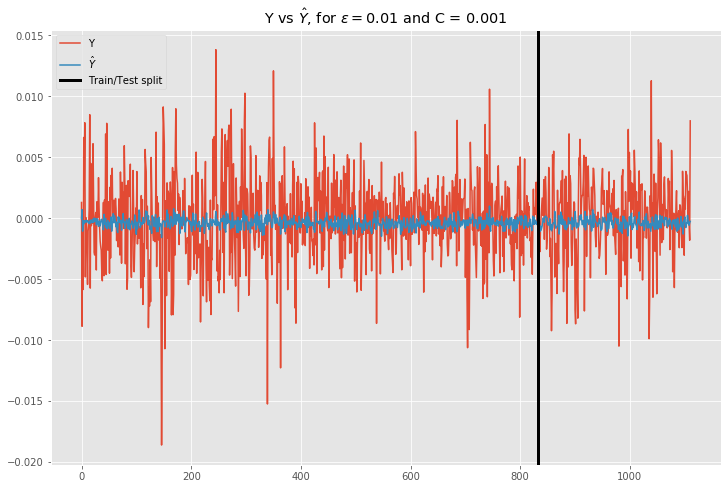

In [143]:
train_set = 0.75
C = 0.001
epsilon = 0.01
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

from sklearn.svm import SVR
N = len(y)
k = int(train_set*N)
X_train = X[:k,:]
y_train = y[:k]
model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
X_test = X[k:,:]
y_test = y[k:].reshape(-1,1)
y_pred1 = model.predict(X_train).reshape(-1,1)
y_pred2 = model.predict(X_test).reshape(-1,1)
y_true = y
y_hat = np.concatenate((y_pred1, y_pred2), axis=0)
n = len(y_true)
x = np.arange(0,n, 1)

plt.plot(x, y_true)
plt.plot(x, y_hat)
#plt.plot(x, [y_train.mean() + y_train.std()]*n, '--', linewidth=3, color='black')
#plt.plot(x, [y_train.mean() - y_train.std()]*n, '--', linewidth=3, color='black')
plt.axvline(x=k, linewidth=3, color='black')
plt.title('Y vs $\hat{Y}$, for $\epsilon = $' + str(epsilon) + ' and C = ' + str(C))
plt.legend(['Y', '$\hat{Y}$', 'Train/Test split'])
plt.show()

We want to predict portfolio return which is very volatile. Therefore, simply referring to a mean error is not exactly what we are interested in, we would like our predictions to capture the volatility of the returns. In general, a high epsilon leads to the minimal mean error but to no volatility at all for the predictions, and same goes for low C. 

Text(0.5, 1.0, '$\\hat{Y}$ standard deviation vs. $\\epsilon$')

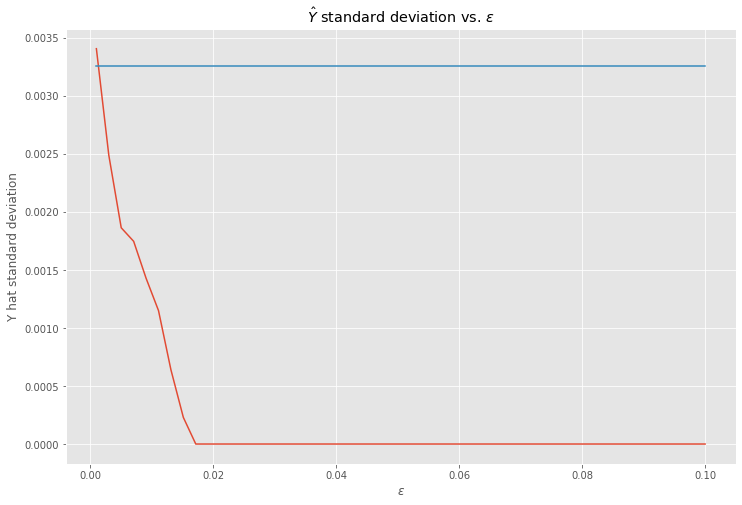

In [181]:
stds=[]
C = 1
train_set = 0.75
from sklearn.svm import SVR
epsilons = np.linspace(0.001, 0.1)
for epsilon in epsilons:
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon, C=1).fit(X_train, y_train)
    X_test = X[k:,:]
    y_test = y[k:].reshape(-1,1)
    y_pred = model.predict(X_test).reshape(-1,1)
    vol = y_pred.std() 
    stds.append(vol)

plt.plot(epsilons, stds)
plt.plot(epsilons, [y_test.std()]*len(epsilons))
plt.xlabel('$\epsilon$')
plt.ylabel('Y hat standard deviation')
plt.title('$\hat{Y}$ standard deviation vs. $\epsilon$')
    
    
    
    
    

Text(0.5, 1.0, '$\\hat{Y}$ RMSE vs. $\\epsilon$')

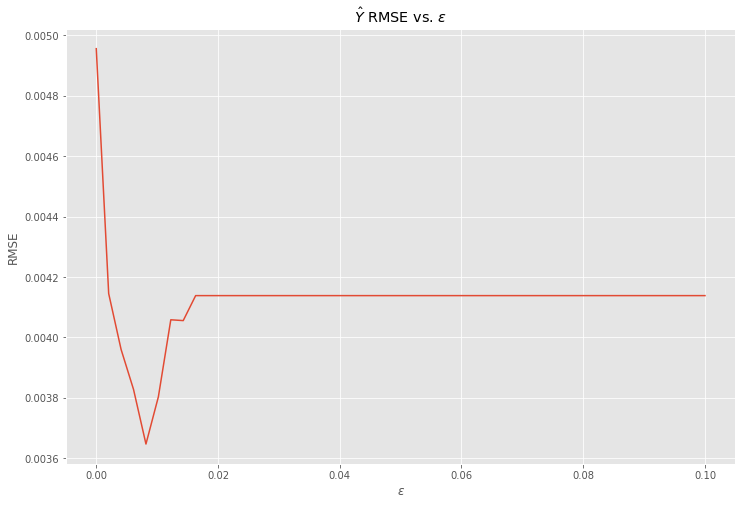

In [186]:
C = 1
errors = []
from sklearn.metrics import mean_squared_error
epsilons = np.linspace(0, 0.1)
for epsilon in epsilons:
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon, C=1).fit(X_train, y_train)
    X_test = X[k:,:]
    y_test = y[k:].reshape(-1,1)
    y_pred = model.predict(X_test).reshape(-1,1)
    error = mean_squared_error(y_pred, y_test, squared=False)
    errors.append(error)
plt.plot(epsilons, errors)
plt.xlabel('$\epsilon$')
plt.ylabel('RMSE')
plt.title('$\hat{Y}$ RMSE vs. $\epsilon$')

Text(0.5, 1.0, '$\\hat{Y}$ standard deviation vs. $\\epsilon$')

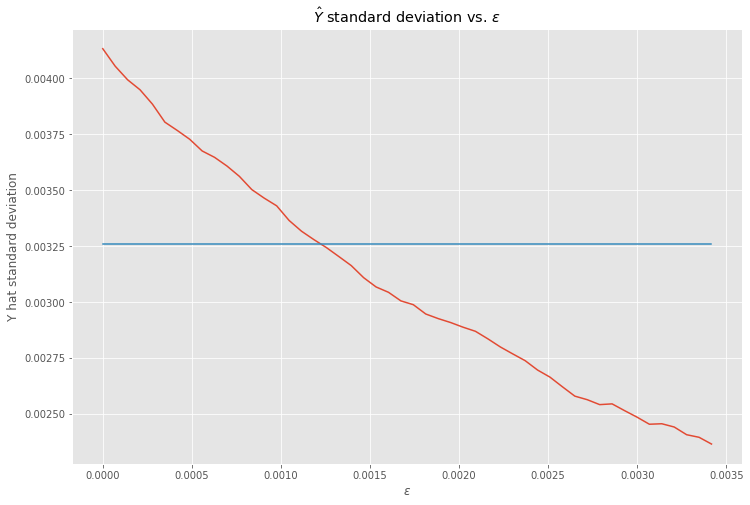

In [184]:
stds=[]
C = 1
train_set = 0.75
from sklearn.svm import SVR
epsilons = np.linspace(0, y.std())
for epsilon in epsilons:
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon, C=1).fit(X_train, y_train)
    X_test = X[k:,:]
    y_test = y[k:].reshape(-1,1)
    y_pred = model.predict(X_test).reshape(-1,1)
    vol = y_pred.std() 
    stds.append(vol)

plt.plot(epsilons, stds)
plt.plot(epsilons, [y_test.std()]*len(epsilons))
plt.xlabel('$\epsilon$')
plt.ylabel('Y hat standard deviation')
plt.title('$\hat{Y}$ standard deviation vs. $\epsilon$')

In [ ]:
C = 1
errors = []
from sklearn.metrics import mean_squared_error
epsilons = np.linspace(0, y.std())
for epsilon in epsilons:
    N = len(y)
    k = int(train_set*N)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon, C=1).fit(X_train, y_train)
    X_test = X[k:,:]
    y_test = y[k:].reshape(-1,1)
    y_pred = model.predict(X_test).reshape(-1,1)
    error = mean_squared_error(y_pred, y_test, squared=False)
    errors.append(error)
plt.plot(epsilons, errors)
plt.xlabel('$\epsilon$')
plt.ylabel('RMSE')
plt.title('$\hat{Y}$ RMSE vs. $\epsilon$')

In [177]:
min(errors)

0.0036886285775541102

In [178]:
np.argmin(errors)

4

In [176]:
epsilons[4]

0.009081632653061226

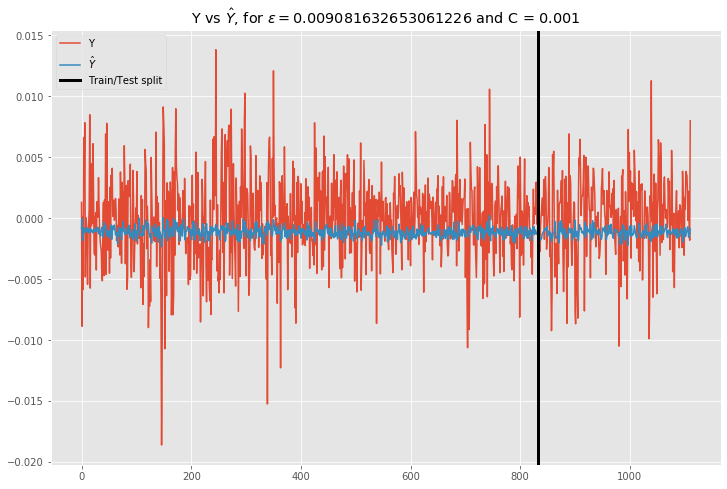

In [179]:
train_set = 0.75
C = 0.001
epsilon = epsilons[4]
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

from sklearn.svm import SVR
N = len(y)
k = int(train_set*N)
X_train = X[:k,:]
y_train = y[:k]
model = SVR(epsilon=epsilon, C=C).fit(X_train, y_train)
X_test = X[k:,:]
y_test = y[k:].reshape(-1,1)
y_pred1 = model.predict(X_train).reshape(-1,1)
y_pred2 = model.predict(X_test).reshape(-1,1)
y_true = y
y_hat = np.concatenate((y_pred1, y_pred2), axis=0)
n = len(y_true)
x = np.arange(0,n, 1)

plt.plot(x, y_true)
plt.plot(x, y_hat)
#plt.plot(x, [y_train.mean() + y_train.std()]*n, '--', linewidth=3, color='black')
#plt.plot(x, [y_train.mean() - y_train.std()]*n, '--', linewidth=3, color='black')
plt.axvline(x=k, linewidth=3, color='black')
plt.title('Y vs $\hat{Y}$, for $\epsilon = $' + str(epsilon) + ' and C = ' + str(C))
plt.legend(['Y', '$\hat{Y}$', 'Train/Test split'])
plt.show()

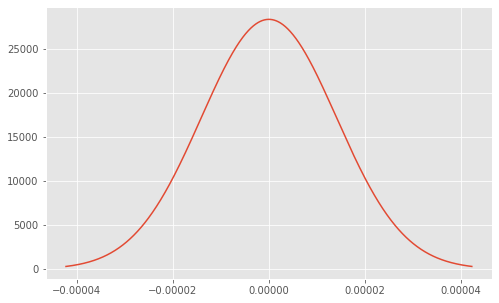

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
sigma = sigma_g
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [95]:
stats.shapiro(errors)

(0.9858047366142273, 0.00024830611073412)

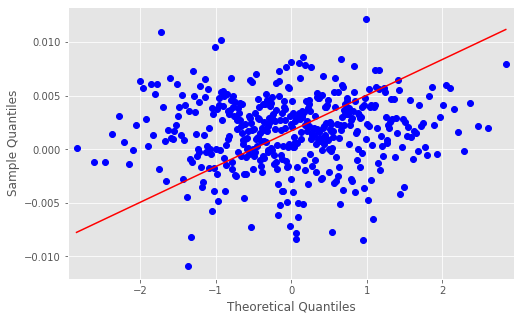

In [100]:
from statsmodels.graphics.gofplots import qqplot
qqplot(np.array(errors), line='s')
plt.show()

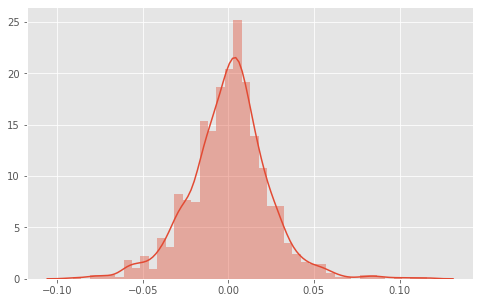

In [128]:
import seaborn as sns
sns.distplot(X[:,10], kde=True)

In [132]:
stats.kstest(errors, 'norm')[1]

2.6070996615756175e-105

In [130]:
stats.kstest(errors, 'laplace')

KstestResult(statistic=0.5060332157590494, pvalue=7.675539039640812e-106)

In [117]:
bin_values = np.arange(start=-0.01,stop=0.01, step=0.001 )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26c7deb8>]],
      dtype=object)

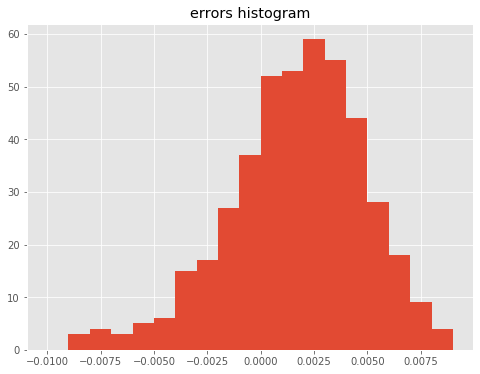

In [121]:
pd.DataFrame(errors, columns=['errors histogram']).hist(bins=bin_values, figsize=[8,6])

In [ ]:
def epsilon_error(y_test, y_pred, epsilon):
    

In [103]:
def ts_crossval(X, y, init_train_set, algo):
    
    from sklearn.metrics import mean_squared_error
    from sklearn.svm import SVR
    
    errors = []
    
    N = len(y)
    
    init_train_point = int(init_train_set * N)
    for i in range(init_train_point, len(X)-1):
        X_train = X[:i, :]
        y_train = y[:i]
        model = algo.fit(X_train, y_train)
        X_test = X[i+1:, :]
        y_test = y[i+1:]
        y_pred = model.predict(X_test)
        error = mean_squared_error(y_test, y_pred, squared=False)
        errors.append(error)
    
    model_performance = np.mean(errors)
    
    return model_performance
        
        
        
    

In [104]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

model_perf = ts_crossval(X, y, init_train_set=0.75, algo=SVR(epsilon=0.001))
print(model_perf)

0.004202691680108455
CPU times: user 1min 4s, sys: 286 ms, total: 1min 4s
Wall time: 1min 5s


In [105]:
from scipy.stats import entropy
KL_dist = entropy

In [19]:
y.std()

0.003416079893089063

In [20]:
algo = SVR(epsilon=y.std())
model = algo.fit(X, y)
y_pred = model.predict(X)

In [21]:
df = np.concatenate((y_pred.reshape(-1,1), y.reshape(-1,1)), axis=1)
df2 = pd.DataFrame(data=df, columns=['y_pred', 'y'])
df2.index = data['Date']
df2.plot()

In [22]:
df2 = pd.DataFrame(data=df, columns=['y_pred', 'y'])
df2.index = data['Date']

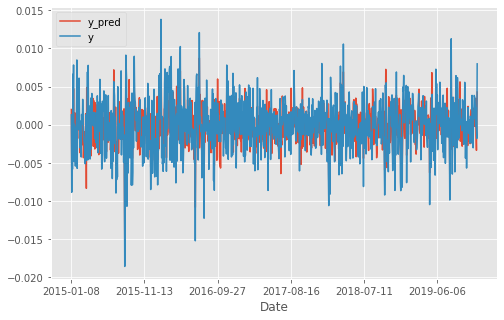

In [23]:
df2.plot()

In [8]:
bonds = ['Switzerland10Y', 'Japan10Y', 'Germany10Y', 'France10Y', 'US10Y']
indices = ['CAC40', 'DAX', 'DOWJONES', 'EURO100', 'NIKKEI225', 'SP500', 'VIX']
commos = ['GOLD', 'OIL', 'SILVER']
currencies = ['EURCHF', 'EURGBP', 'EURUSD', 'GBPUSD', 'USDJPY']

CPU times: user 452 ms, sys: 10.3 ms, total: 462 ms
Wall time: 464 ms


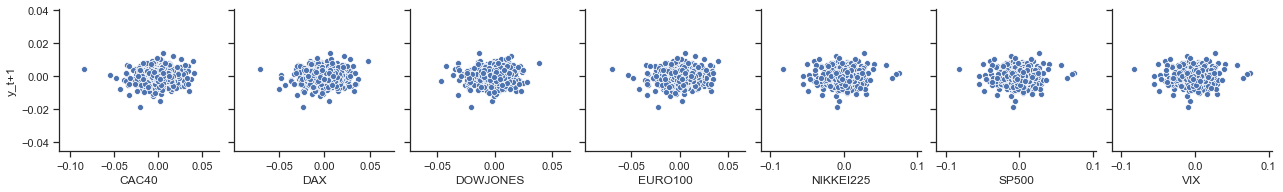

In [9]:
%%time
sns.set(style="ticks")
sns.pairplot(data, x_vars = indices, y_vars='y_t+1')

CPU times: user 182 ms, sys: 5.09 ms, total: 187 ms
Wall time: 187 ms


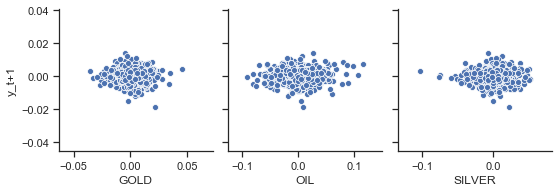

In [10]:
%%time
sns.set(style="ticks")
sns.pairplot(data, x_vars = commos, y_vars='y_t+1')

CPU times: user 296 ms, sys: 6.28 ms, total: 303 ms
Wall time: 302 ms


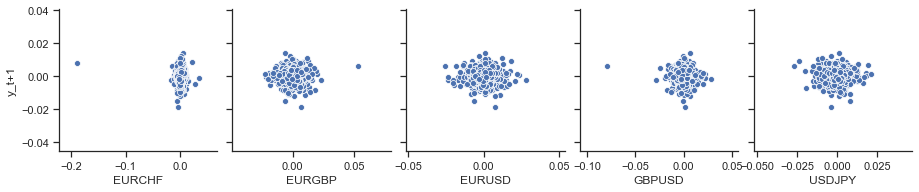

In [11]:
%%time
sns.set(style="ticks")
sns.pairplot(data, x_vars = currencies, y_vars='y_t+1')

In [25]:
data

Date       y_t  Switzerland10Y  Japan10Y  Germany10Y  France10Y  \
0     2015-01-07 -0.000804         0.00221   0.00288     0.00453    0.00744   
1     2015-01-08  0.006036         0.00191   0.00299     0.00472    0.00780   
2     2015-01-09  0.001280         0.00201   0.00289     0.00512    0.00799   
3     2015-01-13 -0.008880         0.00236   0.00282     0.00482    0.00781   
4     2015-01-14  0.000123         0.00205   0.00267     0.00477    0.00741   
...          ...       ...             ...       ...         ...        ...   
1108  2019-12-17  0.002091        -0.00580  -0.00022    -0.00275    0.00022   
1109  2019-12-18 -0.000193        -0.00582  -0.00006    -0.00293    0.00009   
1110  2019-12-19  0.002190        -0.00546  -0.00013    -0.00248    0.00051   
1111  2019-12-20 -0.000567        -0.00530  -0.00007    -0.00234    0.00066   
1112  2019-12-23 -0.001817        -0.00514   0.00008    -0.00250    0.00055   

        US10Y     CAC40       DAX  DOWJONES  ...       VIX      GOLD  \
0     0.01968 -0.006799 -0.000370 -0.007456  ... -0.030652  0.012711   
1     0.01975  0.007133  0.005111  0.012180  ...  0.000127 -0.007161   
2     0.02004  0.035227  0.033009  0.018221  ...  0.016550 -0.001819   
3     0.01997 -0.019225 -0.019410 -0.009567  ...  0.001783  0.006270   
4     0.01876  0.026263  0.029865 -0.006998  ... -0.006418  0.001297   
...       ...       ...       ...       ...  ...       ...       ...   
1108  0.01849  0.012198  0.009362  0.003566  ... -0.002949 -0.000407   
1109  0.01861 -0.003913 -0.008978  0.001107  ...  0.004739 -0.000271   
1110  0.01891 -0.001452 -0.004954 -0.000987  ... -0.005487 -0.001357   
1111  0.01947  0.002125 -0.000772  0.004864  ... -0.002911  0.003796   
1112  0.01935  0.008213  0.008062  0.002749  ... -0.002023 -0.002371   

           OIL    SILVER    EURCHF    EURGBP    EURUSD    GBPUSD    USDJPY  \
0    -0.043081  0.025869 -0.000141  0.001177 -0.000620 -0.001741 -0.008413   
1     0.014910 -0.005617 -0.000358  0.002604 -0.005346 -0.007918 -0.006317   
2     0.002874 -0.009677  0.000000 -0.001454 -0.003320 -0.002011  0.005177   
3    -0.008852  0.002138  0.000025 -0.002134 -0.003379 -0.001299  0.004208   
4    -0.003915  0.035060 -0.000175 -0.002139 -0.003306 -0.001260  0.000981   
...        ...       ...       ...       ...       ...       ...       ...   
1108  0.002328  0.006307 -0.006638  0.003596 -0.005522 -0.009095 -0.000119   
1109  0.012051 -0.002412  0.000438  0.007201  0.001124 -0.006070  0.001607   
1110 -0.000164 -0.001474 -0.002084  0.012719  0.001293 -0.011390 -0.000548   
1111  0.004748  0.006175 -0.003052 -0.000577 -0.003184 -0.002660  0.000320   
1112 -0.012823  0.004095 -0.001185  0.006104  0.000901 -0.005352 -0.001535   

         y_t+1  
0     0.006036  
1     0.001280  
2    -0.008880  
3     0.000123  
4    -0.005860  
...        ...  
1108 -0.000193  
1109  0.002190  
1110 -0.000567  
1111 -0.001817  
1112  0.007977  

[1113 rows x 23 columns]

In [26]:
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1,1)

In [27]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [28]:
X

array([[-0.21816055,  1.80226794,  1.21496957, ..., -0.10753208,
        -0.27513181, -1.61865888],
       [ 1.78544297,  1.67340965,  1.27788352, ..., -0.98504826,
        -1.30046566, -1.21729455],
       [ 0.39229532,  1.71636241,  1.22068902, ..., -0.60877577,
        -0.31990606,  0.98321533],
       ...,
       [ 0.65879712, -1.49220918, -0.50658504, ...,  0.24777359,
        -1.87670354, -0.11282012],
       [-0.14877791, -1.42348475, -0.47226834, ..., -0.58354372,
        -0.42767482,  0.05321377],
       [-0.51487283, -1.35476033, -0.38647658, ...,  0.17497696,
        -0.8744319 , -0.30178169]])

In [29]:
y

array([[ 1.77875152],
       [ 0.38902617],
       [-2.57989924],
       ...,
       [-0.1507179 ],
       [-0.5159135 ],
       [ 2.34605222]])

In [30]:
from sklearn.svm import SVR
regressor = SVR(kernel='poly')
regressor.fit(X,y.ravel())

In [31]:
regressor = SVR(kernel='poly')
regressor.fit(X,y.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [32]:
regressor.predict(X)

array([ 1.67875024,  0.28897202,  0.5744844 , ...,  0.11278706,
        0.09932519, -0.10968692])

In [33]:
y.ravel()

array([ 1.77875152,  0.38902617, -2.57989924, ..., -0.1507179 ,
       -0.5159135 ,  2.34605222])

In [23]:
estimated_return = pd.DataFrame(regressor.predict(X), columns=['y_t+1 hat'])

y_t+1 hat
0      1.678743
1      0.172811
2      0.292074
3      0.351651
4     -0.757218
...         ...
1108  -0.141628
1109  -0.026528
1110  -0.005422
1111   0.083035
1112  -0.070139

[1113 rows x 1 columns]

In [ ]:
def plot_linear_regression(data, exo_var, endo_var):
    from sklearn.linear_model import LinearRegression
    Y = data[exo_var].values.reshape(-1,1)
    X = data[endo_var].values.reshape(-1,1)
    model = LinearRegression().fit(X,Y)
    Y_pred = model.predict(X)
    R_squared = model.score(X,Y)
    alpha, beta = [model.intercept_[0], model.coef_[0]]
    plt.scatter(X,Y)
    plt.plot(X,Y_pred, color='red')
    plt.xlabel(endo_var)
    plt.ylabel(exo_var)
    plt.legend(['y = ' + str(round(alpha,5)) + '+ ' + str(round(float(beta), 4)) + 'X'])
    plt.title('Linear Regression of ' + exo_var + ' against  ' + endo_var + ', $R^2$ = ' + str(R_squared))

def plot_heatmap_corr(data, exo_var, factors):
    Y = [exo_var]
    subdata = data[Y+factors]
    corrMatrix = subdata.corr()
    plt.figure(figsize=(15,12))
    sns.heatmap(corrMatrix, annot=True, cmap='Greens')